# Seoul Bike Trip Duration Prediction

<img src="Features_Description.png" style="float:right;" width="500"/>

### Context
- Trip duration is the most fundamental measure in all modes of transportation. 
- Hence, it is crucial to predict the trip-time precisely for the advancement of Intelligent Transport Systems (ITS) and traveller information systems. 
- In order to predict the trip duration, data mining techniques are employed in this paper to predict the trip duration of rental bikes in Seoul Bike sharing system. 
- The prediction is carried out with the combination of Seoul Bike data and weather data.

### Content
- The Data used include trip duration, trip distance, pickup-dropoff latitude and longitude, 
temperature, precipitation, wind speed, humidity, solar radiation, snowfall, ground temperature and 1-hour average dust concentration.

### Acknowledgements
- V E, Sathishkumar (2020), "Seoul Bike Trip duration prediction", Mendeley Data, V1, doi: 10.17632/gtfh9z865f.1
- Sathishkumar V E, Jangwoo Park, Yongyun Cho, (2019), Seoul bike trip duration prediction using data mining techniques, IET Intelligent Transport Systems, doi: 10.1049/iet-its.2019.0796

### Goal
- Predict the trip duration

### Steps
- Exploratory Data Analysis (EDA)
- Data Preprocessing
- Feature Selection / Transformation
- **Mahcine Learning Algorithm**
- **Feature Importance / Engineering**
- **Hyperparameter Tuning**
- **Explainable AL/ML**
- Model Deployment

## Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from helper_functions import *

from timeit import default_timer as timer

## Data

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_val, X_test, y_train, y_val, y_test = \
joblib.load('data/X_train.pkl'),\
joblib.load('data/X_val.pkl'),\
joblib.load('data/X_test.pkl'),\
joblib.load('data/y_train.pkl'),\
joblib.load('data/y_val.pkl'),\
joblib.load('data/y_test.pkl')

rfe_features = X_train.columns

train_dataset = X_train.copy()
train_dataset['Duration'] = y_train

In [3]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((3964624, 10), (495578, 10), (495579, 10), (3964624,), (495578,), (495579,))

In [4]:
train_dataset

,Distance,Haversine,Phour,Pmin,Dhour,Dmin,Temp,Humid,Solar,Dust,Duration
71152,1110,0.711671,17,23,17,29,4.8,38.0,0.47,64.0,5
3611655,2600,1.159844,17,57,18,13,24.3,31.0,1.17,22.0,14
52753,2200,0.847054,13,49,14,42,-1.3,35.0,1.18,62.0,52
4716811,4370,3.123298,8,26,8,49,2.0,84.0,0.03,59.0,22
3867208,3600,2.344361,9,36,9,50,12.2,51.0,1.02,20.0,14
...,...,...,...,...,...,...,...,...,...,...,...
4457994,400,0.368593,8,50,8,53,11.3,89.0,0.01,94.0,3
2541668,2290,1.545385,19,14,19,28,33.5,54.0,0.35,21.0,13
250565,8490,3.400058,19,14,20,12,8.8,49.0,0.05,27.0,55
229772,1860,1.380952,8,29,8,42,3.8,56.0,0.32,14.0,12


### Feature scaling

In [5]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_val = scalar.transform(X_val)
X_test = scalar.transform(X_test)

joblib.dump(scalar, 'models/scalar.joblib')

['models/scalar.joblib']

## Machine Learning Algorithms

In [6]:
def fit_ML_model(modelName, model, error=pd.DataFrame(
    [], index=['Train Loss','Val Loss', 'Test Loss', 'y_mean','Time (s)'])):

    from sklearn.metrics import mean_squared_error
    
    start = timer()
    
    model.fit(X_train, y_train)
    rmse_train = mean_squared_error(y_train, model.predict(X_train))**0.5
    rmse_val = mean_squared_error(y_val, model.predict(X_val))**0.5
    rmse_test = mean_squared_error(y_test, model.predict(X_test))**0.5

    end = timer()

    error[modelName] = [rmse_train, rmse_val, rmse_test, y_train.mean(), end-start]

    return model, error

###  Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression

modelName = 'LinReg'
lr, error = fit_ML_model(modelName, LinearRegression())

feature_importances = pd.DataFrame(abs(lr.coef_), index=rfe_features, columns=[modelName])
feature_importances[modelName] /= feature_importances[modelName].max()

joblib.dump(lr, 'models/LinReg.pkl', compress=3)

error

,LinReg
Train Loss,4.145283
Val Loss,3.886713
Test Loss,4.274747
y_mean,20.644918
Time (s),2.279095


### Random Forest

In [8]:
from sklearn.ensemble import RandomForestRegressor

modelName = 'RandForest'
rf = RandomForestRegressor(n_estimators=100, min_samples_split=5, n_jobs=-1)
rf, error = fit_ML_model(modelName, rf)

feature_importances[modelName] = rf.feature_importances_
feature_importances[modelName] /= feature_importances[modelName].max()

joblib.dump(rf, 'models/RandForest.joblib', compress=3)

error

,LinReg,RandForest
Train Loss,4.145283,1.603564
Val Loss,3.886713,3.412316
Test Loss,4.274747,3.416343
y_mean,20.644918,20.644918
Time (s),2.279095,527.488950


### XGBoost

In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

modelName = 'XGBoost'
xgb = XGBRegressor(learning_rate=0.3, n_estimators=100, n_jobs=-1,
                   tree_method='exact', eval_set=[(X_val, y_val)], 
                   early_stopping_rounds=10, verbose=1)
xgb, error = fit_ML_model(modelName, xgb)

feature_importances[modelName] = xgb.feature_importances_
feature_importances[modelName] /= feature_importances[modelName].max()

joblib.dump(xgb, 'models/XGBoost.joblib', compress=3)

error

[13:43:58] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds, eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,LinReg,RandForest,XGBoost
Train Loss,4.145283,1.603564,3.687873
Val Loss,3.886713,3.412316,3.757414
Test Loss,4.274747,3.416343,3.770613
y_mean,20.644918,20.644918,20.644918
Time (s),2.279095,527.488950,133.771750


### Neural Network

In [11]:
import tensorflow as tf
from tensorflow import keras

nodes = 64
n_hidden = 2
activation = 'relu'

ann = tf.keras.Sequential(keras.layers.Dense(nodes, activation=activation, input_shape=X_train.shape[1:]))

for _ in range(n_hidden-1):  
    ann.add(keras.layers.Dense(nodes, activation=activation))

ann.add(keras.layers.Dense(1))

ann.summary()

2021-09-22 13:46:13.068019: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-09-22 13:46:15.967280: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-22 13:46:15.968973: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-22 13:46:16.031317: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: Tesla K40m computeCapability: 3.5
coreClock: 0.745GHz coreCount: 15 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 268.58GiB/s
2021-09-22 13:46:16.032317: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:83:00.0 name: Tesla K40m computeCapability: 3.5
coreClock: 0.745GHz coreCount: 15 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 268.58GiB/s
2021-09-22 13:46:16.032

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [12]:
epochs = 1000
batch_size = 100000

lr = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=lr) 
ann.compile(loss='mean_squared_error', optimizer=optimizer)

checkpoint_cb = keras.callbacks.ModelCheckpoint("models/ANN.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

start = timer()
history = ann.fit(X_train, y_train, validation_data=(X_val, y_val), 
                  epochs=epochs, batch_size=batch_size, validation_batch_size=batch_size,
                  callbacks=[checkpoint_cb, early_stopping_cb])

end = timer()

2021-09-22 13:46:17.981612: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-22 13:46:17.982519: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499895000 Hz


Epoch 1/1000


2021-09-22 13:46:18.612704: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


40/40 [==============================] - 2s 35ms/step - loss: 706.5669 - val_loss: 519.7015
Epoch 2/1000
40/40 [==============================] - 1s 15ms/step - loss: 433.3735 - val_loss: 217.2462
Epoch 3/1000
40/40 [==============================] - 1s 15ms/step - loss: 202.9332 - val_loss: 179.0398
Epoch 4/1000
40/40 [==============================] - 1s 15ms/step - loss: 175.5763 - val_loss: 165.8292
Epoch 5/1000
40/40 [==============================] - 1s 15ms/step - loss: 163.3008 - val_loss: 154.1003
Epoch 6/1000
40/40 [==============================] - 1s 15ms/step - loss: 152.0120 - val_loss: 143.1824
Epoch 7/1000
40/40 [==============================] - 1s 15ms/step - loss: 141.2017 - val_loss: 132.8438
Epoch 8/1000
40/40 [==============================] - 1s 15ms/step - loss: 130.6085 - val_loss: 123.3557
Epoch 9/1000
40/40 [==============================] - 1s 15ms/step - loss: 121.5772 - val_loss: 114.9119
Epoch 10/1000
40/40 [==============================] - 1s 15ms/step 

Epoch 81/1000
40/40 [==============================] - 1s 15ms/step - loss: 3.5767 - val_loss: 3.4660
Epoch 82/1000
40/40 [==============================] - 1s 15ms/step - loss: 3.4292 - val_loss: 3.4345
Epoch 83/1000
40/40 [==============================] - 1s 15ms/step - loss: 3.4624 - val_loss: 3.4022
Epoch 84/1000
40/40 [==============================] - 1s 14ms/step - loss: 3.2381 - val_loss: 3.3716
Epoch 85/1000
40/40 [==============================] - 1s 15ms/step - loss: 3.3611 - val_loss: 3.3400
Epoch 86/1000
40/40 [==============================] - 1s 14ms/step - loss: 3.3095 - val_loss: 3.3077
Epoch 87/1000
40/40 [==============================] - 1s 15ms/step - loss: 3.3277 - val_loss: 3.2771
Epoch 88/1000
40/40 [==============================] - 1s 15ms/step - loss: 3.2867 - val_loss: 3.2459
Epoch 89/1000
40/40 [==============================] - 1s 15ms/step - loss: 3.1154 - val_loss: 3.2192
Epoch 90/1000
40/40 [==============================] - 1s 15ms/step - loss: 3.0371

40/40 [==============================] - 1s 14ms/step - loss: 1.7437 - val_loss: 1.8313
Epoch 161/1000
40/40 [==============================] - 1s 15ms/step - loss: 1.7548 - val_loss: 1.8250
Epoch 162/1000
40/40 [==============================] - 1s 15ms/step - loss: 1.7707 - val_loss: 1.8225
Epoch 163/1000
40/40 [==============================] - 1s 15ms/step - loss: 1.7449 - val_loss: 1.8178
Epoch 164/1000
40/40 [==============================] - 1s 15ms/step - loss: 1.7543 - val_loss: 1.8119
Epoch 165/1000
40/40 [==============================] - 1s 15ms/step - loss: 1.7387 - val_loss: 1.8117
Epoch 166/1000
40/40 [==============================] - 1s 15ms/step - loss: 1.7570 - val_loss: 1.8029
Epoch 167/1000
40/40 [==============================] - 1s 16ms/step - loss: 1.7579 - val_loss: 1.8096
Epoch 168/1000
40/40 [==============================] - 1s 15ms/step - loss: 1.7554 - val_loss: 1.8005
Epoch 169/1000
40/40 [==============================] - 1s 15ms/step - loss: 1.7597 - va

40/40 [==============================] - 1s 14ms/step - loss: 1.6021 - val_loss: 1.6646
Epoch 240/1000
40/40 [==============================] - 1s 14ms/step - loss: 1.5716 - val_loss: 1.6619
Epoch 241/1000
40/40 [==============================] - 1s 14ms/step - loss: 1.5769 - val_loss: 1.6562
Epoch 242/1000
40/40 [==============================] - 1s 14ms/step - loss: 1.5891 - val_loss: 1.6552
Epoch 243/1000
40/40 [==============================] - 1s 15ms/step - loss: 1.5877 - val_loss: 1.6531
Epoch 244/1000
40/40 [==============================] - 1s 16ms/step - loss: 1.6056 - val_loss: 1.6535
Epoch 245/1000
40/40 [==============================] - 1s 14ms/step - loss: 1.5815 - val_loss: 1.6518
Epoch 246/1000
40/40 [==============================] - 1s 15ms/step - loss: 1.5908 - val_loss: 1.6537
Epoch 247/1000
40/40 [==============================] - 1s 15ms/step - loss: 1.5885 - val_loss: 1.6616
Epoch 248/1000
40/40 [==============================] - 1s 15ms/step - loss: 1.5625 - va

In [13]:
# still need to find a good way to determine feature importance using NN --> SHAP (later)
# feature_importances['NN_CPU'] =np.mean(abs(ann.weights[0]), axis=1)

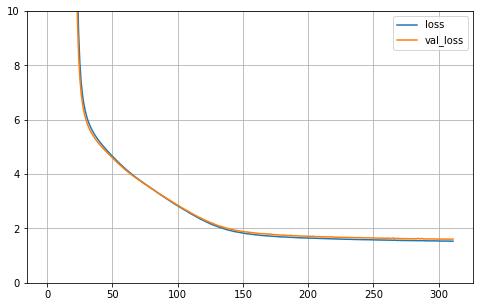

In [14]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 10)
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train, ann.predict(X_train, batch_size=batch_size))**0.5
rmse_val = mean_squared_error(y_val, ann.predict(X_val, batch_size=batch_size))**0.5
rmse_test = mean_squared_error(y_test, ann.predict(X_test, batch_size=batch_size))**0.5
error['NN_CPU'] = [rmse_train, rmse_val, rmse_test, y_train.mean(), end-start]
error

,LinReg,RandForest,XGBoost,NN_CPU
Train Loss,4.145283,1.603564,3.687873,1.237161
Val Loss,3.886713,3.412316,3.757414,1.265332
Test Loss,4.274747,3.416343,3.770613,1.271157
y_mean,20.644918,20.644918,20.644918,20.644918
Time (s),2.279095,527.488950,133.771750,194.456366


### Plotting best results (NN)

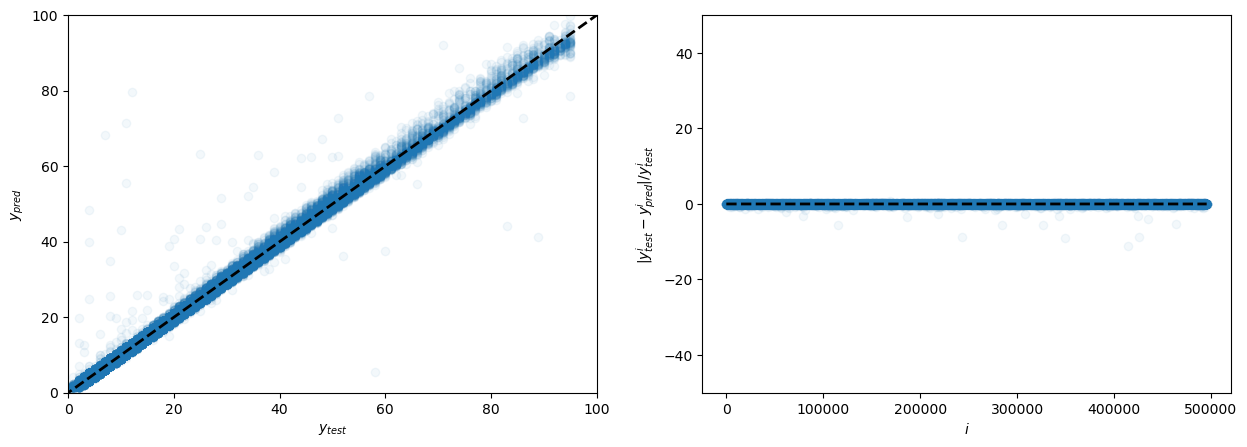

In [16]:
y_pred = ann.predict(X_test, batch_size=batch_size)
rel_res = (y_test.values-y_pred[:,0])/y_test.values

plot_idx = np.random.choice(range(len(y_test)), size=len(y_test)//10, replace=False)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5), dpi=100)

ax[0].scatter(y_test.values[plot_idx], y_pred[:,0][plot_idx], alpha=0.05);
ax[0].set_xlabel('$y_{test}$')
ax[0].set_ylabel('$y_{pred}$')
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,100)
ax[0].plot(range(-10,130), range(-10,130), '--k', lw=2);

ax[1].scatter(np.arange(len(rel_res))[plot_idx], rel_res[plot_idx], alpha=0.05);
ax[1].set_xlabel('$i$')
ax[1].set_ylabel('$|y_{test}^i-y_{pred}^i|/y_{test}^i$');
ax[1].plot(range(len(rel_res)), 0*np.arange(len(rel_res)), '--k', lw=2);
ax[1].set_ylim(-50,50);

# sns.kdeplot(y_test.values-y_pred[:,0], ax=ax[1], shade=True)
# ax[1].set_xlim(-50,50);

## Feature Importance

In [17]:
df_corr = train_dataset.corr()
feature_importances['Duration_Corr'] = df_corr['Duration'].abs().sort_values()[:-1]

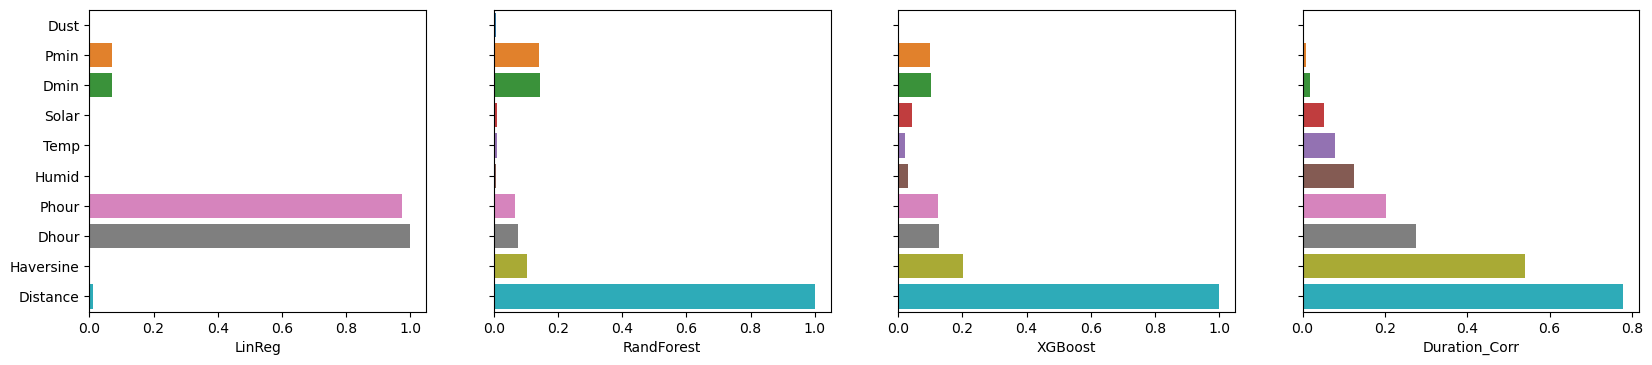

In [18]:
feature_importances = feature_importances.sort_values('Duration_Corr')

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,4), dpi=100, sharey=True)

sns.barplot(y=feature_importances.index, x= feature_importances.LinReg, ax=ax[0])
sns.barplot(y=feature_importances.index, x= feature_importances.RandForest, ax=ax[1])
sns.barplot(y=feature_importances.index, x= feature_importances.XGBoost, ax=ax[2])
sns.barplot(y=feature_importances.index, x= feature_importances.Duration_Corr, ax=ax[3]);

## Hyperparameters Tuning
Sklearn's ```RandomizedSearchCV``` with ```keras.wrappers.scikit_learn.KerasRegressor(model)```

In [19]:
def build_model(n_hidden=1, n_neurons=16, learning_rate=1e-3, input_shape=[10], activation='relu'): 
    model = keras.models.Sequential() 
    model.add(keras.layers.InputLayer(input_shape=input_shape)) 
    for _ in range(n_hidden): 
        model.add(keras.layers.Dense(n_neurons, activation=activation)) 
    model.add(keras.layers.Dense(1)) 
    optimizer = keras.optimizers.Adam(lr=learning_rate) 
    model.compile(loss="mse", optimizer=optimizer) 
    return model

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [24]:
from sklearn.model_selection import RandomizedSearchCV

epochs = 1000
batch_size = 100000

param_distribs = { 
    "n_hidden": np.arange(1, 6).tolist(), 
    "n_neurons": np.arange(1, 101).tolist(), 
    "learning_rate": np.linspace(3e-4, 3e-2, 100).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=20, cv=3, n_jobs=1, verbose=1)
start = timer()
rnd_search_cv.fit(X_train, y_train, validation_data=(X_val, y_val), 
                  epochs=epochs, batch_size=batch_size, validation_batch_size=batch_size,
                  callbacks=[keras.callbacks.EarlyStopping(patience=5)])
end = timer()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Epoch 1/1000
27/27 [==============================] - 1s 29ms/step - loss: 379.4566 - val_loss: 145.1790
Epoch 2/1000
27/27 [==============================] - 1s 21ms/step - loss: 133.9492 - val_loss: 109.9474
Epoch 3/1000
27/27 [==============================] - 1s 21ms/step - loss: 101.2611 - val_loss: 69.1809
Epoch 4/1000
27/27 [==============================] - 1s 22ms/step - loss: 54.7654 - val_loss: 19.3022
Epoch 5/1000
27/27 [==============================] - 1s 22ms/step - loss: 16.4104 - val_loss: 11.8436
Epoch 6/1000
27/27 [==============================] - 1s 22ms/step - loss: 10.7601 - val_loss: 9.9511
Epoch 7/1000
27/27 [==============================] - 1s 21ms/step - loss: 9.6797 - val_loss: 9.5908
Epoch 8/1000
27/27 [==============================] - 1s 20ms/step - loss: 9.3989 - val_loss: 10.0910
Epoch 9/1000
27/27 [==============================] - 1s 22ms/step - loss: 9.6308 - val_loss: 8.9685
Epoch 10/1000

Epoch 7/1000
27/27 [==============================] - 1s 21ms/step - loss: 9.0128 - val_loss: 9.1468
Epoch 8/1000
27/27 [==============================] - 1s 21ms/step - loss: 9.2084 - val_loss: 9.2791
Epoch 9/1000
27/27 [==============================] - 1s 22ms/step - loss: 9.6638 - val_loss: 8.8748
Epoch 10/1000
27/27 [==============================] - 1s 21ms/step - loss: 9.5412 - val_loss: 8.7927
Epoch 11/1000
27/27 [==============================] - 1s 21ms/step - loss: 8.8882 - val_loss: 8.5931
Epoch 12/1000
27/27 [==============================] - 1s 21ms/step - loss: 9.0889 - val_loss: 8.8845
Epoch 13/1000
27/27 [==============================] - 1s 21ms/step - loss: 8.7152 - val_loss: 8.3041
Epoch 14/1000
27/27 [==============================] - 1s 21ms/step - loss: 8.6770 - val_loss: 8.1669
Epoch 15/1000
27/27 [==============================] - 1s 22ms/step - loss: 9.1628 - val_loss: 8.1060
Epoch 16/1000
27/27 [==============================] - 1s 21ms/step - loss: 8.5246 - 

27/27 [==============================] - 1s 21ms/step - loss: 1.7458 - val_loss: 1.8665
Epoch 37/1000
27/27 [==============================] - 1s 21ms/step - loss: 1.9216 - val_loss: 1.7845
Epoch 38/1000
27/27 [==============================] - 1s 21ms/step - loss: 1.8334 - val_loss: 1.8245
Epoch 39/1000
27/27 [==============================] - 1s 20ms/step - loss: 1.8433 - val_loss: 2.4836
Epoch 40/1000
41299/41299 [==============================] - 52s 1ms/step - loss: 1.8453
Epoch 1/1000
27/27 [==============================] - 1s 19ms/step - loss: 760.2526 - val_loss: 747.2463
Epoch 2/1000
27/27 [==============================] - 0s 10ms/step - loss: 744.2279 - val_loss: 730.7072
Epoch 3/1000
27/27 [==============================] - 0s 10ms/step - loss: 728.4089 - val_loss: 711.1478
Epoch 4/1000
27/27 [==============================] - 0s 9ms/step - loss: 707.6437 - val_loss: 688.1777
Epoch 5/1000
27/27 [==============================] - 0s 9ms/step - loss: 684.1085 - val_loss: 661

27/27 [==============================] - 0s 9ms/step - loss: 119.8265 - val_loss: 118.6059
Epoch 74/1000
27/27 [==============================] - 0s 9ms/step - loss: 118.9453 - val_loss: 117.5879
Epoch 75/1000
27/27 [==============================] - 0s 10ms/step - loss: 117.7835 - val_loss: 116.6031
Epoch 76/1000
27/27 [==============================] - 0s 8ms/step - loss: 116.6868 - val_loss: 115.6453
Epoch 77/1000
27/27 [==============================] - 0s 9ms/step - loss: 115.7807 - val_loss: 114.7144
Epoch 78/1000
27/27 [==============================] - 0s 9ms/step - loss: 114.8812 - val_loss: 113.8082
Epoch 79/1000
27/27 [==============================] - 0s 9ms/step - loss: 113.8105 - val_loss: 112.9253
Epoch 80/1000
27/27 [==============================] - 0s 8ms/step - loss: 113.1757 - val_loss: 112.0626
Epoch 81/1000
27/27 [==============================] - 0s 9ms/step - loss: 112.3345 - val_loss: 111.2198
Epoch 82/1000
27/27 [==============================] - 0s 9ms/step -

27/27 [==============================] - 0s 10ms/step - loss: 63.3964 - val_loss: 62.5246
Epoch 152/1000
27/27 [==============================] - 0s 9ms/step - loss: 62.7932 - val_loss: 61.6682
Epoch 153/1000
27/27 [==============================] - 0s 9ms/step - loss: 61.9726 - val_loss: 60.7991
Epoch 154/1000
27/27 [==============================] - 0s 9ms/step - loss: 61.1358 - val_loss: 59.9187
Epoch 155/1000
27/27 [==============================] - 0s 9ms/step - loss: 60.0932 - val_loss: 59.0299
Epoch 156/1000
27/27 [==============================] - 0s 9ms/step - loss: 59.0592 - val_loss: 58.1300
Epoch 157/1000
27/27 [==============================] - 0s 9ms/step - loss: 58.0568 - val_loss: 57.2208
Epoch 158/1000
27/27 [==============================] - 0s 10ms/step - loss: 57.1295 - val_loss: 56.3005
Epoch 159/1000
27/27 [==============================] - 0s 8ms/step - loss: 56.4161 - val_loss: 55.3740
Epoch 160/1000
27/27 [==============================] - 0s 9ms/step - loss: 5

Epoch 230/1000
27/27 [==============================] - 0s 9ms/step - loss: 10.3910 - val_loss: 10.0604
Epoch 231/1000
27/27 [==============================] - 0s 9ms/step - loss: 10.7634 - val_loss: 9.8641
Epoch 232/1000
27/27 [==============================] - 0s 9ms/step - loss: 10.1223 - val_loss: 9.6761
Epoch 233/1000
27/27 [==============================] - 0s 8ms/step - loss: 10.4267 - val_loss: 9.4989
Epoch 234/1000
27/27 [==============================] - 0s 9ms/step - loss: 10.0692 - val_loss: 9.3292
Epoch 235/1000
27/27 [==============================] - 0s 9ms/step - loss: 9.7322 - val_loss: 9.1709
Epoch 236/1000
27/27 [==============================] - 0s 9ms/step - loss: 9.4594 - val_loss: 9.0184
Epoch 237/1000
27/27 [==============================] - 0s 9ms/step - loss: 10.5595 - val_loss: 8.8755
Epoch 238/1000
27/27 [==============================] - 0s 9ms/step - loss: 9.3307 - val_loss: 8.7356
Epoch 239/1000
27/27 [==============================] - 0s 9ms/step - loss:

27/27 [==============================] - 0s 10ms/step - loss: 7.4086 - val_loss: 6.7609
Epoch 311/1000
27/27 [==============================] - 0s 10ms/step - loss: 8.3004 - val_loss: 6.7617
Epoch 312/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.9338 - val_loss: 6.7623
Epoch 313/1000
41299/41299 [==============================] - 51s 1ms/step - loss: 7.0758
Epoch 1/1000
27/27 [==============================] - 2s 39ms/step - loss: 749.6343 - val_loss: 736.6356
Epoch 2/1000
27/27 [==============================] - 0s 9ms/step - loss: 735.4439 - val_loss: 722.5433
Epoch 3/1000
27/27 [==============================] - 0s 9ms/step - loss: 720.3372 - val_loss: 707.3591
Epoch 4/1000
27/27 [==============================] - 0s 9ms/step - loss: 704.5450 - val_loss: 690.4067
Epoch 5/1000
27/27 [==============================] - 0s 10ms/step - loss: 687.3857 - val_loss: 671.1673
Epoch 6/1000
27/27 [==============================] - 0s 9ms/step - loss: 667.9674 - val_loss: 

27/27 [==============================] - 0s 9ms/step - loss: 118.8489 - val_loss: 117.9468
Epoch 75/1000
27/27 [==============================] - 0s 9ms/step - loss: 117.9540 - val_loss: 117.3525
Epoch 76/1000
27/27 [==============================] - 0s 9ms/step - loss: 117.7302 - val_loss: 116.7568
Epoch 77/1000
27/27 [==============================] - 0s 9ms/step - loss: 116.8656 - val_loss: 116.1610
Epoch 78/1000
27/27 [==============================] - 0s 9ms/step - loss: 116.4837 - val_loss: 115.5627
Epoch 79/1000
27/27 [==============================] - 0s 9ms/step - loss: 115.7057 - val_loss: 114.9617
Epoch 80/1000
27/27 [==============================] - 0s 10ms/step - loss: 115.2542 - val_loss: 114.3573
Epoch 81/1000
27/27 [==============================] - 0s 9ms/step - loss: 114.3715 - val_loss: 113.7498
Epoch 82/1000
27/27 [==============================] - 0s 9ms/step - loss: 113.9629 - val_loss: 113.1375
Epoch 83/1000
27/27 [==============================] - 0s 11ms/step 

27/27 [==============================] - 0s 9ms/step - loss: 61.0235 - val_loss: 59.9840
Epoch 153/1000
27/27 [==============================] - 0s 9ms/step - loss: 59.9758 - val_loss: 59.0167
Epoch 154/1000
27/27 [==============================] - 0s 9ms/step - loss: 58.8315 - val_loss: 58.0509
Epoch 155/1000
27/27 [==============================] - 0s 9ms/step - loss: 57.9358 - val_loss: 57.0862
Epoch 156/1000
27/27 [==============================] - 0s 8ms/step - loss: 56.9220 - val_loss: 56.1193
Epoch 157/1000
27/27 [==============================] - 0s 8ms/step - loss: 55.9012 - val_loss: 55.1530
Epoch 158/1000
27/27 [==============================] - 0s 9ms/step - loss: 54.9231 - val_loss: 54.1905
Epoch 159/1000
27/27 [==============================] - 0s 9ms/step - loss: 54.1521 - val_loss: 53.2258
Epoch 160/1000
27/27 [==============================] - 0s 9ms/step - loss: 53.2595 - val_loss: 52.2694
Epoch 161/1000
27/27 [==============================] - 0s 9ms/step - loss: 52.

Epoch 231/1000
27/27 [==============================] - 0s 9ms/step - loss: 11.7878 - val_loss: 11.9429
Epoch 232/1000
27/27 [==============================] - 0s 9ms/step - loss: 11.6695 - val_loss: 11.8328
Epoch 233/1000
27/27 [==============================] - 0s 9ms/step - loss: 11.8184 - val_loss: 11.7280
Epoch 234/1000
27/27 [==============================] - 0s 9ms/step - loss: 11.9576 - val_loss: 11.6046
Epoch 235/1000
27/27 [==============================] - 0s 10ms/step - loss: 11.5702 - val_loss: 11.4878
Epoch 236/1000
27/27 [==============================] - 0s 10ms/step - loss: 11.8319 - val_loss: 11.3905
Epoch 237/1000
27/27 [==============================] - 0s 10ms/step - loss: 11.2605 - val_loss: 11.3040
Epoch 238/1000
27/27 [==============================] - 0s 10ms/step - loss: 11.5896 - val_loss: 11.2284
Epoch 239/1000
27/27 [==============================] - 0s 9ms/step - loss: 10.6198 - val_loss: 11.1565
Epoch 240/1000
27/27 [==============================] - 0s 9

27/27 [==============================] - 0s 9ms/step - loss: 10.8616 - val_loss: 10.5073
Epoch 310/1000
27/27 [==============================] - 0s 9ms/step - loss: 9.8224 - val_loss: 10.5065
Epoch 311/1000
27/27 [==============================] - 0s 9ms/step - loss: 10.7200 - val_loss: 10.5059
Epoch 312/1000
27/27 [==============================] - 0s 9ms/step - loss: 10.8269 - val_loss: 10.5056
Epoch 313/1000
27/27 [==============================] - 0s 9ms/step - loss: 10.3255 - val_loss: 10.5046
Epoch 314/1000
27/27 [==============================] - 0s 9ms/step - loss: 9.6287 - val_loss: 10.5047
Epoch 315/1000
27/27 [==============================] - 0s 9ms/step - loss: 10.2168 - val_loss: 10.5056
Epoch 316/1000
27/27 [==============================] - 0s 10ms/step - loss: 10.2715 - val_loss: 10.5041
Epoch 317/1000
27/27 [==============================] - 0s 9ms/step - loss: 9.7670 - val_loss: 10.5048
Epoch 318/1000
27/27 [==============================] - 0s 10ms/step - loss: 10.6

Epoch 42/1000
27/27 [==============================] - 0s 9ms/step - loss: 205.2672 - val_loss: 203.1972
Epoch 43/1000
27/27 [==============================] - 0s 9ms/step - loss: 203.1472 - val_loss: 200.8829
Epoch 44/1000
27/27 [==============================] - 0s 9ms/step - loss: 200.8904 - val_loss: 198.7307
Epoch 45/1000
27/27 [==============================] - 0s 9ms/step - loss: 198.4948 - val_loss: 196.7038
Epoch 46/1000
27/27 [==============================] - 0s 9ms/step - loss: 196.6851 - val_loss: 194.7847
Epoch 47/1000
27/27 [==============================] - 0s 9ms/step - loss: 195.0124 - val_loss: 192.9468
Epoch 48/1000
27/27 [==============================] - 0s 9ms/step - loss: 193.1251 - val_loss: 191.1772
Epoch 49/1000
27/27 [==============================] - 0s 9ms/step - loss: 191.3936 - val_loss: 189.4524
Epoch 50/1000
27/27 [==============================] - 0s 8ms/step - loss: 189.7304 - val_loss: 187.7546
Epoch 51/1000
27/27 [==============================] - 

27/27 [==============================] - 0s 9ms/step - loss: 104.3188 - val_loss: 103.5112
Epoch 120/1000
27/27 [==============================] - 0s 9ms/step - loss: 103.8766 - val_loss: 102.8964
Epoch 121/1000
27/27 [==============================] - 0s 8ms/step - loss: 103.4205 - val_loss: 102.2839
Epoch 122/1000
27/27 [==============================] - 0s 9ms/step - loss: 102.6624 - val_loss: 101.6712
Epoch 123/1000
27/27 [==============================] - 0s 9ms/step - loss: 102.0537 - val_loss: 101.0621
Epoch 124/1000
27/27 [==============================] - 0s 10ms/step - loss: 101.7106 - val_loss: 100.4538
Epoch 125/1000
27/27 [==============================] - 0s 9ms/step - loss: 100.7249 - val_loss: 99.8534
Epoch 126/1000
27/27 [==============================] - 0s 9ms/step - loss: 100.4587 - val_loss: 99.2582
Epoch 127/1000
27/27 [==============================] - 0s 9ms/step - loss: 99.5402 - val_loss: 98.6681
Epoch 128/1000
27/27 [==============================] - 0s 9ms/s

27/27 [==============================] - 0s 9ms/step - loss: 37.6311 - val_loss: 36.7011
Epoch 198/1000
27/27 [==============================] - 0s 10ms/step - loss: 37.0552 - val_loss: 35.6679
Epoch 199/1000
27/27 [==============================] - 0s 9ms/step - loss: 35.2415 - val_loss: 34.6478
Epoch 200/1000
27/27 [==============================] - 0s 8ms/step - loss: 34.6657 - val_loss: 33.6623
Epoch 201/1000
27/27 [==============================] - 0s 9ms/step - loss: 33.7621 - val_loss: 32.7121
Epoch 202/1000
27/27 [==============================] - 0s 9ms/step - loss: 32.8525 - val_loss: 31.8093
Epoch 203/1000
27/27 [==============================] - 0s 9ms/step - loss: 32.2184 - val_loss: 30.9643
Epoch 204/1000
27/27 [==============================] - 0s 8ms/step - loss: 31.4689 - val_loss: 30.1556
Epoch 205/1000
27/27 [==============================] - 0s 8ms/step - loss: 30.2958 - val_loss: 29.3840
Epoch 206/1000
27/27 [==============================] - 0s 9ms/step - loss: 29

27/27 [==============================] - 0s 9ms/step - loss: 8.6938 - val_loss: 8.1370
Epoch 277/1000
27/27 [==============================] - 0s 9ms/step - loss: 8.9301 - val_loss: 8.0823
Epoch 278/1000
27/27 [==============================] - 0s 8ms/step - loss: 9.3096 - val_loss: 8.0274
Epoch 279/1000
27/27 [==============================] - 0s 9ms/step - loss: 9.1029 - val_loss: 7.9764
Epoch 280/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.3904 - val_loss: 7.9239
Epoch 281/1000
27/27 [==============================] - 0s 10ms/step - loss: 8.7397 - val_loss: 7.8811
Epoch 282/1000
27/27 [==============================] - 0s 9ms/step - loss: 10.8256 - val_loss: 7.8374
Epoch 283/1000
27/27 [==============================] - 0s 9ms/step - loss: 8.4563 - val_loss: 7.7922
Epoch 284/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.8947 - val_loss: 7.7513
Epoch 285/1000
27/27 [==============================] - 0s 9ms/step - loss: 8.5242 - val_loss

27/27 [==============================] - 0s 8ms/step - loss: 7.5795 - val_loss: 6.8635
Epoch 357/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.2456 - val_loss: 6.8585
Epoch 358/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.5297 - val_loss: 6.8530
Epoch 359/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.5449 - val_loss: 6.8484
Epoch 360/1000
27/27 [==============================] - 0s 9ms/step - loss: 8.2628 - val_loss: 6.8449
Epoch 361/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.4538 - val_loss: 6.8407
Epoch 362/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.3999 - val_loss: 6.8363
Epoch 363/1000
27/27 [==============================] - 0s 8ms/step - loss: 6.7392 - val_loss: 6.8321
Epoch 364/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.8694 - val_loss: 6.8280
Epoch 365/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.8863 - val_loss: 6.

27/27 [==============================] - 0s 10ms/step - loss: 7.2039 - val_loss: 6.6694
Epoch 437/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.4740 - val_loss: 6.6683
Epoch 438/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.4675 - val_loss: 6.6679
Epoch 439/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.2895 - val_loss: 6.6666
Epoch 440/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.8658 - val_loss: 6.6661
Epoch 441/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.2993 - val_loss: 6.6639
Epoch 442/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.1110 - val_loss: 6.6628
Epoch 443/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.9989 - val_loss: 6.6628
Epoch 444/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.7144 - val_loss: 6.6614
Epoch 445/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.9980 - val_loss: 

27/27 [==============================] - 0s 9ms/step - loss: 6.9949 - val_loss: 6.5917
Epoch 517/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.3564 - val_loss: 6.5912
Epoch 518/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.6615 - val_loss: 6.5909
Epoch 519/1000
27/27 [==============================] - 0s 10ms/step - loss: 6.7557 - val_loss: 6.5884
Epoch 520/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.7138 - val_loss: 6.5881
Epoch 521/1000
27/27 [==============================] - 0s 9ms/step - loss: 5.9752 - val_loss: 6.5875
Epoch 522/1000
27/27 [==============================] - 0s 8ms/step - loss: 6.4169 - val_loss: 6.5858
Epoch 523/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.0409 - val_loss: 6.5865
Epoch 524/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.1131 - val_loss: 6.5836
Epoch 525/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.3247 - val_loss: 

27/27 [==============================] - 0s 9ms/step - loss: 7.0839 - val_loss: 6.3449
Epoch 597/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.2239 - val_loss: 6.3326
Epoch 598/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.3819 - val_loss: 6.3221
Epoch 599/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.1324 - val_loss: 6.3061
Epoch 600/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.6755 - val_loss: 6.2933
Epoch 601/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.1804 - val_loss: 6.2786
Epoch 602/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.6240 - val_loss: 6.2647
Epoch 603/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.5530 - val_loss: 6.2502
Epoch 604/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.1814 - val_loss: 6.2366
Epoch 605/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.7308 - val_loss: 6

27/27 [==============================] - 0s 9ms/step - loss: 4.8959 - val_loss: 5.1610
Epoch 677/1000
27/27 [==============================] - 0s 9ms/step - loss: 5.7576 - val_loss: 5.1440
Epoch 678/1000
27/27 [==============================] - 0s 9ms/step - loss: 5.2271 - val_loss: 5.1288
Epoch 679/1000
27/27 [==============================] - 0s 9ms/step - loss: 5.6915 - val_loss: 5.1126
Epoch 680/1000
27/27 [==============================] - 0s 9ms/step - loss: 5.4082 - val_loss: 5.0972
Epoch 681/1000
27/27 [==============================] - 0s 8ms/step - loss: 5.9920 - val_loss: 5.0817
Epoch 682/1000
27/27 [==============================] - 0s 10ms/step - loss: 5.4617 - val_loss: 5.0663
Epoch 683/1000
27/27 [==============================] - 0s 9ms/step - loss: 5.4138 - val_loss: 5.0499
Epoch 684/1000
27/27 [==============================] - 0s 10ms/step - loss: 5.0605 - val_loss: 5.0343
Epoch 685/1000
27/27 [==============================] - 0s 9ms/step - loss: 4.8035 - val_loss: 

27/27 [==============================] - 0s 8ms/step - loss: 4.4674 - val_loss: 3.9118
Epoch 757/1000
27/27 [==============================] - 0s 9ms/step - loss: 4.3731 - val_loss: 3.8951
Epoch 758/1000
27/27 [==============================] - 0s 9ms/step - loss: 4.0207 - val_loss: 3.8804
Epoch 759/1000
27/27 [==============================] - 0s 9ms/step - loss: 4.6263 - val_loss: 3.8631
Epoch 760/1000
27/27 [==============================] - 0s 9ms/step - loss: 4.1281 - val_loss: 3.8475
Epoch 761/1000
27/27 [==============================] - 0s 9ms/step - loss: 4.3040 - val_loss: 3.8302
Epoch 762/1000
27/27 [==============================] - 0s 10ms/step - loss: 3.7642 - val_loss: 3.8138
Epoch 763/1000
27/27 [==============================] - 0s 9ms/step - loss: 3.9118 - val_loss: 3.7985
Epoch 764/1000
27/27 [==============================] - 0s 9ms/step - loss: 3.9129 - val_loss: 3.7820
Epoch 765/1000
27/27 [==============================] - 0s 9ms/step - loss: 4.1865 - val_loss: 3

27/27 [==============================] - 0s 9ms/step - loss: 2.9534 - val_loss: 2.6579
Epoch 837/1000
27/27 [==============================] - 0s 9ms/step - loss: 3.1261 - val_loss: 2.6480
Epoch 838/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.9103 - val_loss: 2.6388
Epoch 839/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.9455 - val_loss: 2.6297
Epoch 840/1000
27/27 [==============================] - 0s 10ms/step - loss: 2.8068 - val_loss: 2.6210
Epoch 841/1000
27/27 [==============================] - 0s 10ms/step - loss: 2.6817 - val_loss: 2.6123
Epoch 842/1000
27/27 [==============================] - 0s 9ms/step - loss: 3.0467 - val_loss: 2.6028
Epoch 843/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.7121 - val_loss: 2.5957
Epoch 844/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.7467 - val_loss: 2.5860
Epoch 845/1000
27/27 [==============================] - 0s 8ms/step - loss: 2.6664 - val_loss: 

27/27 [==============================] - 0s 9ms/step - loss: 2.1856 - val_loss: 2.1451
Epoch 917/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.2589 - val_loss: 2.1399
Epoch 918/1000
27/27 [==============================] - 0s 10ms/step - loss: 2.3508 - val_loss: 2.1364
Epoch 919/1000
27/27 [==============================] - 0s 10ms/step - loss: 2.2210 - val_loss: 2.1309
Epoch 920/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.2311 - val_loss: 2.1285
Epoch 921/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.3556 - val_loss: 2.1236
Epoch 922/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.2443 - val_loss: 2.1193
Epoch 923/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.2640 - val_loss: 2.1155
Epoch 924/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.2827 - val_loss: 2.1115
Epoch 925/1000
27/27 [==============================] - 0s 8ms/step - loss: 2.3407 - val_loss: 

27/27 [==============================] - 0s 9ms/step - loss: 1.9428 - val_loss: 1.8866
Epoch 997/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.9003 - val_loss: 1.8844
Epoch 998/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.9017 - val_loss: 1.8817
Epoch 999/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.8368 - val_loss: 1.8791
Epoch 1000/1000
41299/41299 [==============================] - 51s 1ms/step - loss: 2.0024
Epoch 1/1000
27/27 [==============================] - 1s 26ms/step - loss: 662.5642 - val_loss: 262.2841
Epoch 2/1000
27/27 [==============================] - 0s 18ms/step - loss: 235.6926 - val_loss: 174.6575
Epoch 3/1000
27/27 [==============================] - 0s 18ms/step - loss: 169.1157 - val_loss: 149.9077
Epoch 4/1000
27/27 [==============================] - 0s 18ms/step - loss: 145.0922 - val_loss: 130.2103
Epoch 5/1000
27/27 [==============================] - 0s 19ms/step - loss: 127.7008 - val_loss: 

27/27 [==============================] - 1s 19ms/step - loss: 2.0712 - val_loss: 2.1377
Epoch 76/1000
27/27 [==============================] - 0s 17ms/step - loss: 2.0574 - val_loss: 2.2170
Epoch 77/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.1130 - val_loss: 2.2169
Epoch 78/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.0883 - val_loss: 2.0537
Epoch 79/1000
27/27 [==============================] - 1s 19ms/step - loss: 2.0070 - val_loss: 2.1320
Epoch 80/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.0032 - val_loss: 1.9993
Epoch 81/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.9436 - val_loss: 1.9732
Epoch 82/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.0011 - val_loss: 2.1568
Epoch 83/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.9132 - val_loss: 1.9395
Epoch 84/1000
27/27 [==============================] - 0s 17ms/step - loss: 1.8405 - val_loss: 1

27/27 [==============================] - 0s 17ms/step - loss: 4.0687 - val_loss: 3.8946
Epoch 31/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.9069 - val_loss: 3.8889
Epoch 32/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.8220 - val_loss: 3.7590
Epoch 33/1000
27/27 [==============================] - 1s 20ms/step - loss: 3.9960 - val_loss: 3.6687
Epoch 34/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.7517 - val_loss: 3.6272
Epoch 35/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.5180 - val_loss: 3.5284
Epoch 36/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.6242 - val_loss: 3.4679
Epoch 37/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.4037 - val_loss: 3.3974
Epoch 38/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.4660 - val_loss: 3.3550
Epoch 39/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.4435 - val_loss: 3

27/27 [==============================] - 0s 18ms/step - loss: 1.6482 - val_loss: 1.6244
Epoch 111/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6435 - val_loss: 1.6467
Epoch 112/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6055 - val_loss: 1.6410
Epoch 113/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6091 - val_loss: 1.6399
Epoch 114/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6037 - val_loss: 1.6201
Epoch 115/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6775 - val_loss: 1.8845
Epoch 116/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.7145 - val_loss: 1.6329
Epoch 117/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.6268 - val_loss: 1.6504
Epoch 118/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6618 - val_loss: 1.6369
Epoch 119/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6074 - va

27/27 [==============================] - 0s 17ms/step - loss: 3.5189 - val_loss: 3.5449
Epoch 41/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.3993 - val_loss: 3.4731
Epoch 42/1000
27/27 [==============================] - 0s 17ms/step - loss: 3.3723 - val_loss: 3.4417
Epoch 43/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.2350 - val_loss: 3.3922
Epoch 44/1000
27/27 [==============================] - 0s 17ms/step - loss: 3.1218 - val_loss: 3.3134
Epoch 45/1000
27/27 [==============================] - 0s 17ms/step - loss: 3.2907 - val_loss: 3.2995
Epoch 46/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.2103 - val_loss: 3.2536
Epoch 47/1000
27/27 [==============================] - 0s 17ms/step - loss: 3.1369 - val_loss: 3.1939
Epoch 48/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.0510 - val_loss: 3.1122
Epoch 49/1000
27/27 [==============================] - 0s 17ms/step - loss: 3.0006 - val_loss: 3

27/27 [==============================] - 0s 18ms/step - loss: 1.7320 - val_loss: 1.7683
Epoch 121/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.7152 - val_loss: 1.8491
Epoch 122/1000
27/27 [==============================] - 0s 17ms/step - loss: 1.7666 - val_loss: 1.7601
Epoch 123/1000
27/27 [==============================] - 0s 17ms/step - loss: 1.7759 - val_loss: 1.7437
Epoch 124/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6963 - val_loss: 1.7621
Epoch 125/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6954 - val_loss: 1.7351
Epoch 126/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6828 - val_loss: 1.8602
Epoch 127/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.7709 - val_loss: 1.7658
Epoch 128/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.7308 - val_loss: 1.7283
Epoch 129/1000
27/27 [==============================] - 0s 17ms/step - loss: 1.6770 - va

Epoch 55/1000
27/27 [==============================] - 0s 10ms/step - loss: 8.1857 - val_loss: 7.2985
Epoch 56/1000
27/27 [==============================] - 0s 11ms/step - loss: 8.2361 - val_loss: 7.2882
Epoch 57/1000
27/27 [==============================] - 0s 11ms/step - loss: 8.0328 - val_loss: 7.2797
Epoch 58/1000
27/27 [==============================] - 0s 12ms/step - loss: 7.8416 - val_loss: 7.2707
Epoch 59/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.4659 - val_loss: 7.2660
Epoch 60/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.4788 - val_loss: 7.2568
Epoch 61/1000
27/27 [==============================] - 0s 12ms/step - loss: 7.5693 - val_loss: 7.2546
Epoch 62/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.6118 - val_loss: 7.2453
Epoch 63/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.6391 - val_loss: 7.2392
Epoch 64/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.9042

Epoch 135/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.6312 - val_loss: 6.8790
Epoch 136/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.4637 - val_loss: 6.8642
Epoch 137/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.4572 - val_loss: 6.8552
Epoch 138/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.0098 - val_loss: 6.8467
Epoch 139/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.4728 - val_loss: 6.8237
Epoch 140/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.3356 - val_loss: 6.8246
Epoch 141/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.2835 - val_loss: 6.8046
Epoch 142/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.4057 - val_loss: 6.7811
Epoch 143/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.0876 - val_loss: 6.7730
Epoch 144/1000
27/27 [==============================] - 0s 11ms/step - lo

27/27 [==============================] - 0s 10ms/step - loss: 1.9854 - val_loss: 1.9333
Epoch 215/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.8818 - val_loss: 1.9102
Epoch 216/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.8922 - val_loss: 1.8941
Epoch 217/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.8725 - val_loss: 1.8722
Epoch 218/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.9127 - val_loss: 1.8618
Epoch 219/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7943 - val_loss: 1.8673
Epoch 220/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.8587 - val_loss: 1.8374
Epoch 221/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.8662 - val_loss: 1.8285
Epoch 222/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.7685 - val_loss: 1.8216
Epoch 223/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.8171 - va

27/27 [==============================] - 0s 11ms/step - loss: 77.3605 - val_loss: 72.1552
Epoch 16/1000
27/27 [==============================] - 0s 11ms/step - loss: 70.9239 - val_loss: 65.3403
Epoch 17/1000
27/27 [==============================] - 0s 10ms/step - loss: 64.1967 - val_loss: 58.0539
Epoch 18/1000
27/27 [==============================] - 0s 11ms/step - loss: 56.5744 - val_loss: 50.9171
Epoch 19/1000
27/27 [==============================] - 0s 11ms/step - loss: 49.3994 - val_loss: 43.9972
Epoch 20/1000
27/27 [==============================] - 0s 12ms/step - loss: 42.4126 - val_loss: 37.3955
Epoch 21/1000
27/27 [==============================] - 0s 12ms/step - loss: 35.9643 - val_loss: 31.0466
Epoch 22/1000
27/27 [==============================] - 0s 11ms/step - loss: 29.6925 - val_loss: 24.9437
Epoch 23/1000
27/27 [==============================] - 0s 11ms/step - loss: 23.8441 - val_loss: 20.2934
Epoch 24/1000
27/27 [==============================] - 0s 11ms/step - loss: 19

27/27 [==============================] - 0s 11ms/step - loss: 5.8631 - val_loss: 5.0593
Epoch 96/1000
27/27 [==============================] - 0s 10ms/step - loss: 5.4482 - val_loss: 4.9475
Epoch 97/1000
27/27 [==============================] - 0s 11ms/step - loss: 5.4480 - val_loss: 4.8405
Epoch 98/1000
27/27 [==============================] - 0s 10ms/step - loss: 5.7205 - val_loss: 4.7366
Epoch 99/1000
27/27 [==============================] - 0s 10ms/step - loss: 5.0081 - val_loss: 4.6308
Epoch 100/1000
27/27 [==============================] - 0s 10ms/step - loss: 4.7841 - val_loss: 4.5266
Epoch 101/1000
27/27 [==============================] - 0s 10ms/step - loss: 5.0689 - val_loss: 4.4291
Epoch 102/1000
27/27 [==============================] - 0s 11ms/step - loss: 5.1223 - val_loss: 4.3259
Epoch 103/1000
27/27 [==============================] - 0s 11ms/step - loss: 4.7724 - val_loss: 4.2330
Epoch 104/1000
27/27 [==============================] - 0s 11ms/step - loss: 4.8069 - val_lo

27/27 [==============================] - 0s 11ms/step - loss: 1.9811 - val_loss: 1.8638
Epoch 175/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.9873 - val_loss: 1.8581
Epoch 176/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.8646 - val_loss: 1.8577
Epoch 177/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.8901 - val_loss: 1.8518
Epoch 178/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.8374 - val_loss: 1.8394
Epoch 179/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.8618 - val_loss: 1.8340
Epoch 180/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.8665 - val_loss: 1.8302
Epoch 181/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.8942 - val_loss: 1.8232
Epoch 182/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.9136 - val_loss: 1.8206
Epoch 183/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.8788 - va

41299/41299 [==============================] - 51s 1ms/step - loss: 1.6498
Epoch 1/1000
27/27 [==============================] - 1s 20ms/step - loss: 715.1602 - val_loss: 522.6313
Epoch 2/1000
27/27 [==============================] - 0s 11ms/step - loss: 445.9188 - val_loss: 229.5121
Epoch 3/1000
27/27 [==============================] - 0s 12ms/step - loss: 204.2043 - val_loss: 173.1782
Epoch 4/1000
27/27 [==============================] - 0s 11ms/step - loss: 169.0430 - val_loss: 155.5614
Epoch 5/1000
27/27 [==============================] - 0s 11ms/step - loss: 152.5169 - val_loss: 141.2111
Epoch 6/1000
27/27 [==============================] - 0s 10ms/step - loss: 138.6704 - val_loss: 129.4396
Epoch 7/1000
27/27 [==============================] - 0s 11ms/step - loss: 127.9025 - val_loss: 121.3858
Epoch 8/1000
27/27 [==============================] - 0s 10ms/step - loss: 120.2612 - val_loss: 115.3676
Epoch 9/1000
27/27 [==============================] - 0s 10ms/step - loss: 114.3704 -

27/27 [==============================] - 0s 11ms/step - loss: 7.6963 - val_loss: 7.2437
Epoch 80/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.2464 - val_loss: 7.2344
Epoch 81/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.0936 - val_loss: 7.2200
Epoch 82/1000
27/27 [==============================] - 0s 10ms/step - loss: 6.8114 - val_loss: 7.2098
Epoch 83/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.4865 - val_loss: 7.1975
Epoch 84/1000
27/27 [==============================] - 0s 12ms/step - loss: 6.5987 - val_loss: 7.1889
Epoch 85/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.7700 - val_loss: 7.1783
Epoch 86/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.0879 - val_loss: 7.1661
Epoch 87/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.8205 - val_loss: 7.1521
Epoch 88/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.0136 - val_loss: 7

Epoch 159/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.8930 - val_loss: 6.4481
Epoch 160/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.2422 - val_loss: 6.4377
Epoch 161/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.3459 - val_loss: 6.4194
Epoch 162/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.1630 - val_loss: 6.4020
Epoch 163/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.9966 - val_loss: 6.3843
Epoch 164/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.2908 - val_loss: 6.3699
Epoch 165/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.6442 - val_loss: 6.3560
Epoch 166/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.3221 - val_loss: 6.3348
Epoch 167/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.5262 - val_loss: 6.3131
Epoch 168/1000
27/27 [==============================] - 0s 12ms/step - lo

27/27 [==============================] - 0s 11ms/step - loss: 2.0431 - val_loss: 2.0206
Epoch 239/1000
27/27 [==============================] - 0s 10ms/step - loss: 2.0640 - val_loss: 1.9954
Epoch 240/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.9220 - val_loss: 1.9677
Epoch 241/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.9105 - val_loss: 1.9534
Epoch 242/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.9705 - val_loss: 1.9287
Epoch 243/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.9526 - val_loss: 1.9277
Epoch 244/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.8943 - val_loss: 1.8992
Epoch 245/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.9370 - val_loss: 1.8773
Epoch 246/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.8602 - val_loss: 1.8651
Epoch 247/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.8869 - va

27/27 [==============================] - 1s 21ms/step - loss: 3.4051 - val_loss: 3.8641
Epoch 22/1000
27/27 [==============================] - 1s 23ms/step - loss: 4.3562 - val_loss: 3.5588
Epoch 23/1000
27/27 [==============================] - 1s 23ms/step - loss: 3.4662 - val_loss: 3.4513
Epoch 24/1000
27/27 [==============================] - 1s 22ms/step - loss: 3.5679 - val_loss: 4.6166
Epoch 25/1000
27/27 [==============================] - 1s 21ms/step - loss: 3.7126 - val_loss: 3.4130
Epoch 26/1000
27/27 [==============================] - 1s 22ms/step - loss: 3.2858 - val_loss: 3.2239
Epoch 27/1000
27/27 [==============================] - 1s 22ms/step - loss: 4.0249 - val_loss: 3.8307
Epoch 28/1000
27/27 [==============================] - 1s 21ms/step - loss: 3.2494 - val_loss: 3.0324
Epoch 29/1000
27/27 [==============================] - 1s 21ms/step - loss: 2.9857 - val_loss: 3.0506
Epoch 30/1000
27/27 [==============================] - 1s 21ms/step - loss: 2.9846 - val_loss: 3

27/27 [==============================] - 1s 23ms/step - loss: 1.8517 - val_loss: 1.6913
Epoch 37/1000
27/27 [==============================] - 1s 23ms/step - loss: 1.6668 - val_loss: 1.8765
Epoch 38/1000
27/27 [==============================] - 1s 21ms/step - loss: 1.7380 - val_loss: 2.1102
Epoch 39/1000
27/27 [==============================] - 1s 21ms/step - loss: 1.8562 - val_loss: 1.9085
Epoch 40/1000
27/27 [==============================] - 1s 22ms/step - loss: 1.7016 - val_loss: 1.6680
Epoch 41/1000
27/27 [==============================] - 1s 22ms/step - loss: 2.0453 - val_loss: 2.2768
Epoch 42/1000
27/27 [==============================] - 1s 22ms/step - loss: 1.8232 - val_loss: 1.7595
Epoch 43/1000
27/27 [==============================] - 1s 21ms/step - loss: 1.6578 - val_loss: 1.6552
Epoch 44/1000
27/27 [==============================] - 1s 22ms/step - loss: 1.6040 - val_loss: 1.7044
Epoch 45/1000
27/27 [==============================] - 1s 23ms/step - loss: 1.6605 - val_loss: 1

Epoch 4/1000
27/27 [==============================] - 0s 10ms/step - loss: 152.9838 - val_loss: 140.0348
Epoch 5/1000
27/27 [==============================] - 0s 9ms/step - loss: 136.8857 - val_loss: 127.4186
Epoch 6/1000
27/27 [==============================] - 0s 9ms/step - loss: 125.5072 - val_loss: 118.2588
Epoch 7/1000
27/27 [==============================] - 0s 9ms/step - loss: 116.4493 - val_loss: 110.2955
Epoch 8/1000
27/27 [==============================] - 0s 11ms/step - loss: 109.0550 - val_loss: 103.6418
Epoch 9/1000
27/27 [==============================] - 0s 9ms/step - loss: 102.5966 - val_loss: 97.2638
Epoch 10/1000
27/27 [==============================] - 0s 9ms/step - loss: 96.0926 - val_loss: 90.6634
Epoch 11/1000
27/27 [==============================] - 0s 10ms/step - loss: 89.2838 - val_loss: 83.7527
Epoch 12/1000
27/27 [==============================] - 0s 10ms/step - loss: 82.4006 - val_loss: 76.6003
Epoch 13/1000
27/27 [==============================] - 0s 10ms/s

27/27 [==============================] - 0s 9ms/step - loss: 7.2257 - val_loss: 7.0411
Epoch 85/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.7496 - val_loss: 7.0281
Epoch 86/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.3846 - val_loss: 7.0196
Epoch 87/1000
27/27 [==============================] - 0s 10ms/step - loss: 6.9360 - val_loss: 7.0132
Epoch 88/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.1149 - val_loss: 7.0071
Epoch 89/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.8110 - val_loss: 6.9942
Epoch 90/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.8924 - val_loss: 6.9837
Epoch 91/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.1595 - val_loss: 6.9730
Epoch 92/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.2759 - val_loss: 6.9720
Epoch 93/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.2910 - val_loss: 6.9740

27/27 [==============================] - 0s 9ms/step - loss: 2.1257 - val_loss: 2.0027
Epoch 165/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.0355 - val_loss: 1.9808
Epoch 166/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.0038 - val_loss: 1.9638
Epoch 167/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.9053 - val_loss: 1.9530
Epoch 168/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.9213 - val_loss: 1.9341
Epoch 169/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.9220 - val_loss: 1.9507
Epoch 170/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.9638 - val_loss: 1.9206
Epoch 171/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.8608 - val_loss: 1.9181
Epoch 172/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.8539 - val_loss: 1.8795
Epoch 173/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.8015 - val_loss:

27/27 [==============================] - 0s 9ms/step - loss: 8.3247 - val_loss: 7.2337
Epoch 40/1000
27/27 [==============================] - 0s 10ms/step - loss: 8.6136 - val_loss: 7.2102
Epoch 41/1000
27/27 [==============================] - 0s 10ms/step - loss: 8.0045 - val_loss: 7.1887
Epoch 42/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.7455 - val_loss: 7.1655
Epoch 43/1000
27/27 [==============================] - 0s 11ms/step - loss: 8.4985 - val_loss: 7.1599
Epoch 44/1000
27/27 [==============================] - 0s 10ms/step - loss: 9.1019 - val_loss: 7.1352
Epoch 45/1000
27/27 [==============================] - 0s 10ms/step - loss: 8.0337 - val_loss: 7.1093
Epoch 46/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.7118 - val_loss: 7.1006
Epoch 47/1000
27/27 [==============================] - 0s 10ms/step - loss: 8.3790 - val_loss: 7.0724
Epoch 48/1000
27/27 [==============================] - 0s 10ms/step - loss: 8.2182 - val_loss: 7.0

27/27 [==============================] - 0s 9ms/step - loss: 2.3497 - val_loss: 2.0712
Epoch 120/1000
27/27 [==============================] - 0s 10ms/step - loss: 2.2128 - val_loss: 2.0473
Epoch 121/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.0981 - val_loss: 2.0310
Epoch 122/1000
27/27 [==============================] - 0s 10ms/step - loss: 2.2117 - val_loss: 2.0248
Epoch 123/1000
27/27 [==============================] - 0s 10ms/step - loss: 2.1361 - val_loss: 2.0111
Epoch 124/1000
27/27 [==============================] - 0s 10ms/step - loss: 2.2123 - val_loss: 1.9893
Epoch 125/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.0724 - val_loss: 1.9808
Epoch 126/1000
27/27 [==============================] - 0s 10ms/step - loss: 2.0866 - val_loss: 1.9735
Epoch 127/1000
27/27 [==============================] - 0s 10ms/step - loss: 2.1122 - val_loss: 1.9550
Epoch 128/1000
27/27 [==============================] - 0s 10ms/step - loss: 2.1284 - val_l

Epoch 199/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.7524 - val_loss: 1.7088
Epoch 200/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.6902 - val_loss: 1.7047
Epoch 201/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.7034 - val_loss: 1.7031
Epoch 202/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.7207 - val_loss: 1.7100
Epoch 203/1000
41299/41299 [==============================] - 50s 1ms/step - loss: 1.6566
Epoch 1/1000
27/27 [==============================] - 1s 17ms/step - loss: 690.3364 - val_loss: 426.1510
Epoch 2/1000
27/27 [==============================] - 0s 10ms/step - loss: 342.4524 - val_loss: 193.8196
Epoch 3/1000
27/27 [==============================] - 0s 10ms/step - loss: 187.9184 - val_loss: 164.7970
Epoch 4/1000
27/27 [==============================] - 0s 10ms/step - loss: 159.8063 - val_loss: 142.2882
Epoch 5/1000
27/27 [==============================] - 0s 10ms/step - loss: 138.

27/27 [==============================] - 0s 9ms/step - loss: 6.8157 - val_loss: 6.9401
Epoch 76/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.0939 - val_loss: 6.9367
Epoch 77/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.8382 - val_loss: 6.9186
Epoch 78/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.2841 - val_loss: 6.9179
Epoch 79/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.7643 - val_loss: 6.9167
Epoch 80/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.0252 - val_loss: 6.8936
Epoch 81/1000
27/27 [==============================] - 0s 10ms/step - loss: 6.9046 - val_loss: 6.8841
Epoch 82/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.3331 - val_loss: 6.8845
Epoch 83/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.5970 - val_loss: 6.8738
Epoch 84/1000
27/27 [==============================] - 0s 10ms/step - loss: 6.0622 - val_loss: 6.8683
E

27/27 [==============================] - 0s 9ms/step - loss: 6.4010 - val_loss: 6.2558
Epoch 156/1000
27/27 [==============================] - 0s 10ms/step - loss: 6.3782 - val_loss: 6.2216
Epoch 157/1000
27/27 [==============================] - 0s 10ms/step - loss: 6.7260 - val_loss: 6.2100
Epoch 158/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.4448 - val_loss: 6.1820
Epoch 159/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.1924 - val_loss: 6.1438
Epoch 160/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.4574 - val_loss: 6.0926
Epoch 161/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.0855 - val_loss: 6.0049
Epoch 162/1000
27/27 [==============================] - 0s 10ms/step - loss: 6.1935 - val_loss: 5.9348
Epoch 163/1000
27/27 [==============================] - 0s 9ms/step - loss: 5.4670 - val_loss: 5.8510
Epoch 164/1000
27/27 [==============================] - 0s 9ms/step - loss: 6.4322 - val_loss:

27/27 [==============================] - 0s 9ms/step - loss: 1.7784 - val_loss: 1.7856
Epoch 236/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.8374 - val_loss: 1.7788
Epoch 237/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.7962 - val_loss: 1.7829
Epoch 238/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.8193 - val_loss: 1.7622
Epoch 239/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.7640 - val_loss: 1.7587
Epoch 240/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.8050 - val_loss: 1.7752
Epoch 241/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.7976 - val_loss: 1.7566
Epoch 242/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.8127 - val_loss: 1.7562
Epoch 243/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.7423 - val_loss: 1.7518
Epoch 244/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.8131 - val_loss:

27/27 [==============================] - 1s 20ms/step - loss: 1.8900 - val_loss: 2.0438
Epoch 53/1000
41299/41299 [==============================] - 58s 1ms/step - loss: 2.1830
Epoch 1/1000
27/27 [==============================] - 2s 30ms/step - loss: 447.3463 - val_loss: 153.0647
Epoch 2/1000
27/27 [==============================] - 1s 20ms/step - loss: 143.1987 - val_loss: 120.8436
Epoch 3/1000
27/27 [==============================] - 1s 20ms/step - loss: 115.3835 - val_loss: 97.4454
Epoch 4/1000
27/27 [==============================] - 1s 20ms/step - loss: 90.5782 - val_loss: 59.3680
Epoch 5/1000
27/27 [==============================] - 1s 19ms/step - loss: 47.5109 - val_loss: 22.1663
Epoch 6/1000
27/27 [==============================] - 1s 20ms/step - loss: 18.3352 - val_loss: 12.2465
Epoch 7/1000
27/27 [==============================] - 1s 20ms/step - loss: 10.8884 - val_loss: 8.6095
Epoch 8/1000
27/27 [==============================] - 1s 20ms/step - loss: 8.0894 - val_loss: 7.54

Epoch 22/1000
27/27 [==============================] - 1s 20ms/step - loss: 2.7808 - val_loss: 3.3382
Epoch 23/1000
27/27 [==============================] - 1s 22ms/step - loss: 3.7363 - val_loss: 2.3594
Epoch 24/1000
27/27 [==============================] - 1s 20ms/step - loss: 2.2924 - val_loss: 1.9885
Epoch 25/1000
27/27 [==============================] - 1s 20ms/step - loss: 2.8150 - val_loss: 5.4046
Epoch 26/1000
27/27 [==============================] - 1s 21ms/step - loss: 3.7053 - val_loss: 2.3692
Epoch 27/1000
27/27 [==============================] - 1s 21ms/step - loss: 2.1478 - val_loss: 1.8649
Epoch 28/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.8391 - val_loss: 1.7806
Epoch 29/1000
27/27 [==============================] - 1s 20ms/step - loss: 1.7720 - val_loss: 1.7468
Epoch 30/1000
27/27 [==============================] - 1s 20ms/step - loss: 1.8445 - val_loss: 1.7372
Epoch 31/1000
27/27 [==============================] - 1s 20ms/step - loss: 1.7944

27/27 [==============================] - 0s 12ms/step - loss: 5.5733 - val_loss: 5.5466
Epoch 67/1000
27/27 [==============================] - 0s 11ms/step - loss: 4.9941 - val_loss: 5.4024
Epoch 68/1000
27/27 [==============================] - 0s 12ms/step - loss: 4.9959 - val_loss: 5.3213
Epoch 69/1000
27/27 [==============================] - 0s 11ms/step - loss: 4.9506 - val_loss: 5.1932
Epoch 70/1000
27/27 [==============================] - 0s 11ms/step - loss: 4.7615 - val_loss: 5.0606
Epoch 71/1000
27/27 [==============================] - 0s 11ms/step - loss: 4.6367 - val_loss: 4.9439
Epoch 72/1000
27/27 [==============================] - 0s 12ms/step - loss: 4.4945 - val_loss: 4.8383
Epoch 73/1000
27/27 [==============================] - 0s 12ms/step - loss: 4.2054 - val_loss: 4.7558
Epoch 74/1000
27/27 [==============================] - 0s 13ms/step - loss: 4.5824 - val_loss: 4.6278
Epoch 75/1000
27/27 [==============================] - 0s 11ms/step - loss: 4.2387 - val_loss: 4

27/27 [==============================] - 0s 12ms/step - loss: 1.9321 - val_loss: 1.9647
Epoch 147/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.9286 - val_loss: 1.9731
Epoch 148/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.9190 - val_loss: 1.9448
Epoch 149/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.9033 - val_loss: 2.0180
Epoch 150/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.9292 - val_loss: 1.9799
Epoch 151/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.9720 - val_loss: 2.0860
Epoch 152/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.8396 - val_loss: 1.9100
Epoch 153/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.9523 - val_loss: 1.9113
Epoch 154/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.8698 - val_loss: 1.8974
Epoch 155/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.9127 - va

27/27 [==============================] - 0s 13ms/step - loss: 5.9392 - val_loss: 6.2346
Epoch 53/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.2756 - val_loss: 6.1202
Epoch 54/1000
27/27 [==============================] - 0s 12ms/step - loss: 6.0428 - val_loss: 6.0564
Epoch 55/1000
27/27 [==============================] - 0s 12ms/step - loss: 5.7849 - val_loss: 5.9067
Epoch 56/1000
27/27 [==============================] - 0s 11ms/step - loss: 5.7972 - val_loss: 5.7559
Epoch 57/1000
27/27 [==============================] - 0s 13ms/step - loss: 5.6161 - val_loss: 5.6411
Epoch 58/1000
27/27 [==============================] - 0s 12ms/step - loss: 5.4458 - val_loss: 5.5196
Epoch 59/1000
27/27 [==============================] - 0s 13ms/step - loss: 5.4415 - val_loss: 5.3813
Epoch 60/1000
27/27 [==============================] - 0s 12ms/step - loss: 5.4254 - val_loss: 5.2726
Epoch 61/1000
27/27 [==============================] - 0s 12ms/step - loss: 5.0767 - val_loss: 5

27/27 [==============================] - 0s 12ms/step - loss: 7.5459 - val_loss: 7.8641
Epoch 28/1000
27/27 [==============================] - 0s 12ms/step - loss: 7.3426 - val_loss: 7.8150
Epoch 29/1000
27/27 [==============================] - 0s 13ms/step - loss: 7.2270 - val_loss: 7.7957
Epoch 30/1000
27/27 [==============================] - 0s 12ms/step - loss: 7.2690 - val_loss: 7.7648
Epoch 31/1000
27/27 [==============================] - 0s 13ms/step - loss: 7.5067 - val_loss: 7.7124
Epoch 32/1000
27/27 [==============================] - 0s 12ms/step - loss: 7.2734 - val_loss: 7.6836
Epoch 33/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.4613 - val_loss: 7.6471
Epoch 34/1000
27/27 [==============================] - 0s 12ms/step - loss: 7.4687 - val_loss: 7.6209
Epoch 35/1000
27/27 [==============================] - 0s 14ms/step - loss: 6.9414 - val_loss: 7.5883
Epoch 36/1000
27/27 [==============================] - 0s 13ms/step - loss: 7.0486 - val_loss: 7

27/27 [==============================] - 0s 13ms/step - loss: 1.7748 - val_loss: 1.7287
Epoch 108/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7460 - val_loss: 1.7459
Epoch 109/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.8028 - val_loss: 1.7178
Epoch 110/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.7411 - val_loss: 1.7350
Epoch 111/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.7134 - val_loss: 1.7133
Epoch 112/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.7667 - val_loss: 1.7573
Epoch 113/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7655 - val_loss: 1.7107
Epoch 114/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6905 - val_loss: 1.7318
Epoch 115/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6798 - val_loss: 1.7356
Epoch 116/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.7548 - va

27/27 [==============================] - 0s 12ms/step - loss: 47.1220 - val_loss: 45.2661
Epoch 67/1000
27/27 [==============================] - 0s 12ms/step - loss: 44.6107 - val_loss: 42.9248
Epoch 68/1000
27/27 [==============================] - 0s 12ms/step - loss: 42.6003 - val_loss: 40.5518
Epoch 69/1000
27/27 [==============================] - 0s 12ms/step - loss: 40.1415 - val_loss: 38.1917
Epoch 70/1000
27/27 [==============================] - 0s 12ms/step - loss: 37.8288 - val_loss: 35.9021
Epoch 71/1000
27/27 [==============================] - 0s 13ms/step - loss: 35.4931 - val_loss: 33.7189
Epoch 72/1000
27/27 [==============================] - 0s 12ms/step - loss: 33.3847 - val_loss: 31.6268
Epoch 73/1000
27/27 [==============================] - 0s 12ms/step - loss: 31.3876 - val_loss: 29.6130
Epoch 74/1000
27/27 [==============================] - 0s 13ms/step - loss: 29.1969 - val_loss: 27.6746
Epoch 75/1000
27/27 [==============================] - 0s 12ms/step - loss: 27

27/27 [==============================] - 0s 12ms/step - loss: 4.2900 - val_loss: 4.3351
Epoch 146/1000
27/27 [==============================] - 0s 12ms/step - loss: 4.2923 - val_loss: 4.3189
Epoch 147/1000
27/27 [==============================] - 0s 11ms/step - loss: 4.2522 - val_loss: 4.3046
Epoch 148/1000
27/27 [==============================] - 0s 12ms/step - loss: 4.2336 - val_loss: 4.2906
Epoch 149/1000
27/27 [==============================] - 0s 12ms/step - loss: 4.0598 - val_loss: 4.2765
Epoch 150/1000
27/27 [==============================] - 0s 12ms/step - loss: 4.2423 - val_loss: 4.2621
Epoch 151/1000
27/27 [==============================] - 0s 12ms/step - loss: 4.1912 - val_loss: 4.2480
Epoch 152/1000
27/27 [==============================] - 0s 13ms/step - loss: 4.4770 - val_loss: 4.2340
Epoch 153/1000
27/27 [==============================] - 0s 12ms/step - loss: 4.3274 - val_loss: 4.2205
Epoch 154/1000
27/27 [==============================] - 0s 13ms/step - loss: 4.1927 - va

27/27 [==============================] - 0s 13ms/step - loss: 3.0499 - val_loss: 3.0759
Epoch 225/1000
27/27 [==============================] - 0s 12ms/step - loss: 2.8573 - val_loss: 3.0599
Epoch 226/1000
27/27 [==============================] - 0s 13ms/step - loss: 3.0794 - val_loss: 3.0417
Epoch 227/1000
27/27 [==============================] - 0s 13ms/step - loss: 2.9297 - val_loss: 3.0243
Epoch 228/1000
27/27 [==============================] - 0s 13ms/step - loss: 2.9415 - val_loss: 3.0094
Epoch 229/1000
27/27 [==============================] - 0s 13ms/step - loss: 2.9390 - val_loss: 2.9911
Epoch 230/1000
27/27 [==============================] - 0s 12ms/step - loss: 2.8299 - val_loss: 2.9768
Epoch 231/1000
27/27 [==============================] - 0s 12ms/step - loss: 2.9661 - val_loss: 2.9572
Epoch 232/1000
27/27 [==============================] - 0s 13ms/step - loss: 2.8757 - val_loss: 2.9412
Epoch 233/1000
27/27 [==============================] - 0s 12ms/step - loss: 2.7404 - va

27/27 [==============================] - 0s 12ms/step - loss: 1.9531 - val_loss: 2.0352
Epoch 304/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.9783 - val_loss: 2.0284
Epoch 305/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.9571 - val_loss: 2.0213
Epoch 306/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.9317 - val_loss: 2.0142
Epoch 307/1000
27/27 [==============================] - 0s 12ms/step - loss: 2.0010 - val_loss: 2.0048
Epoch 308/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.9395 - val_loss: 1.9982
Epoch 309/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.9442 - val_loss: 1.9900
Epoch 310/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.9269 - val_loss: 1.9830
Epoch 311/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.8881 - val_loss: 1.9761
Epoch 312/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.8992 - va

27/27 [==============================] - 0s 13ms/step - loss: 1.6834 - val_loss: 1.7331
Epoch 383/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6564 - val_loss: 1.7349
Epoch 384/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6388 - val_loss: 1.7308
Epoch 385/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.5671 - val_loss: 1.7311
Epoch 386/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7248 - val_loss: 1.7294
Epoch 387/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6551 - val_loss: 1.7267
Epoch 388/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6211 - val_loss: 1.7256
Epoch 389/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6265 - val_loss: 1.7244
Epoch 390/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6745 - val_loss: 1.7224
Epoch 391/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6929 - va

27/27 [==============================] - 0s 13ms/step - loss: 1.5785 - val_loss: 1.6581
Epoch 462/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.5835 - val_loss: 1.6576
Epoch 463/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6012 - val_loss: 1.6550
Epoch 464/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.5609 - val_loss: 1.6563
Epoch 465/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.5754 - val_loss: 1.6563
Epoch 466/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.5632 - val_loss: 1.6551
Epoch 467/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.5907 - val_loss: 1.6535
Epoch 468/1000
27/27 [==============================] - ETA: 0s - loss: 1.541 - 0s 12ms/step - loss: 1.5435 - val_loss: 1.6530
Epoch 469/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.5771 - val_loss: 1.6550
Epoch 470/1000
27/27 [==============================] - 0s 12ms/

27/27 [==============================] - 0s 13ms/step - loss: 89.0056 - val_loss: 87.5332
Epoch 50/1000
27/27 [==============================] - 0s 13ms/step - loss: 87.0067 - val_loss: 85.4802
Epoch 51/1000
27/27 [==============================] - 0s 13ms/step - loss: 85.1026 - val_loss: 83.4698
Epoch 52/1000
27/27 [==============================] - 0s 12ms/step - loss: 83.0224 - val_loss: 81.5054
Epoch 53/1000
27/27 [==============================] - 0s 13ms/step - loss: 81.2738 - val_loss: 79.5799
Epoch 54/1000
27/27 [==============================] - 0s 13ms/step - loss: 79.2607 - val_loss: 77.6818
Epoch 55/1000
27/27 [==============================] - 0s 13ms/step - loss: 77.2230 - val_loss: 75.8011
Epoch 56/1000
27/27 [==============================] - 0s 13ms/step - loss: 75.6158 - val_loss: 73.9426
Epoch 57/1000
27/27 [==============================] - 0s 12ms/step - loss: 73.4955 - val_loss: 72.0986
Epoch 58/1000
27/27 [==============================] - 0s 13ms/step - loss: 71

Epoch 128/1000
27/27 [==============================] - 0s 12ms/step - loss: 7.6951 - val_loss: 7.4416
Epoch 129/1000
27/27 [==============================] - 0s 12ms/step - loss: 7.6845 - val_loss: 7.2665
Epoch 130/1000
27/27 [==============================] - 0s 13ms/step - loss: 7.2636 - val_loss: 7.0985
Epoch 131/1000
27/27 [==============================] - 0s 12ms/step - loss: 7.3752 - val_loss: 6.9399
Epoch 132/1000
27/27 [==============================] - 0s 12ms/step - loss: 7.3604 - val_loss: 6.7932
Epoch 133/1000
27/27 [==============================] - 0s 14ms/step - loss: 7.0967 - val_loss: 6.6560
Epoch 134/1000
27/27 [==============================] - 0s 12ms/step - loss: 6.6644 - val_loss: 6.5274
Epoch 135/1000
27/27 [==============================] - 0s 13ms/step - loss: 6.6340 - val_loss: 6.4087
Epoch 136/1000
27/27 [==============================] - 0s 13ms/step - loss: 6.5879 - val_loss: 6.2959
Epoch 137/1000
27/27 [==============================] - 0s 13ms/step - lo

27/27 [==============================] - 0s 12ms/step - loss: 3.7747 - val_loss: 4.0040
Epoch 208/1000
27/27 [==============================] - 0s 11ms/step - loss: 4.1456 - val_loss: 3.9830
Epoch 209/1000
27/27 [==============================] - 0s 12ms/step - loss: 3.9855 - val_loss: 3.9628
Epoch 210/1000
27/27 [==============================] - 0s 14ms/step - loss: 4.0279 - val_loss: 3.9431
Epoch 211/1000
27/27 [==============================] - 0s 12ms/step - loss: 3.9918 - val_loss: 3.9239
Epoch 212/1000
27/27 [==============================] - 0s 14ms/step - loss: 4.0213 - val_loss: 3.9045
Epoch 213/1000
27/27 [==============================] - 0s 14ms/step - loss: 3.7979 - val_loss: 3.8851
Epoch 214/1000
27/27 [==============================] - 0s 13ms/step - loss: 3.9681 - val_loss: 3.8663
Epoch 215/1000
27/27 [==============================] - 0s 13ms/step - loss: 3.8548 - val_loss: 3.8466
Epoch 216/1000
27/27 [==============================] - 0s 13ms/step - loss: 3.9071 - va

27/27 [==============================] - 0s 13ms/step - loss: 2.2932 - val_loss: 2.3371
Epoch 287/1000
27/27 [==============================] - 0s 14ms/step - loss: 2.2576 - val_loss: 2.3199
Epoch 288/1000
27/27 [==============================] - 0s 13ms/step - loss: 2.2937 - val_loss: 2.3027
Epoch 289/1000
27/27 [==============================] - 0s 13ms/step - loss: 2.2301 - val_loss: 2.2880
Epoch 290/1000
27/27 [==============================] - 0s 13ms/step - loss: 2.2355 - val_loss: 2.2712
Epoch 291/1000
27/27 [==============================] - 0s 12ms/step - loss: 2.2551 - val_loss: 2.2576
Epoch 292/1000
27/27 [==============================] - 0s 13ms/step - loss: 2.1961 - val_loss: 2.2418
Epoch 293/1000
27/27 [==============================] - 0s 13ms/step - loss: 2.1458 - val_loss: 2.2274
Epoch 294/1000
27/27 [==============================] - 0s 12ms/step - loss: 2.1704 - val_loss: 2.2150
Epoch 295/1000
27/27 [==============================] - 0s 13ms/step - loss: 2.0741 - va

27/27 [==============================] - 0s 12ms/step - loss: 1.7827 - val_loss: 1.8803
Epoch 366/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.8309 - val_loss: 1.8779
Epoch 367/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.8289 - val_loss: 1.8787
Epoch 368/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.8200 - val_loss: 1.8753
Epoch 369/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.8554 - val_loss: 1.8723
Epoch 370/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.8560 - val_loss: 1.8724
Epoch 371/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.8351 - val_loss: 1.8707
Epoch 372/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7843 - val_loss: 1.8699
Epoch 373/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.8214 - val_loss: 1.8663
Epoch 374/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.8452 - va

27/27 [==============================] - 0s 12ms/step - loss: 1.7297 - val_loss: 1.7662
Epoch 445/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7533 - val_loss: 1.7693
Epoch 446/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7330 - val_loss: 1.7651
Epoch 447/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7278 - val_loss: 1.7625
Epoch 448/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7559 - val_loss: 1.7625
Epoch 449/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7627 - val_loss: 1.7611
Epoch 450/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7679 - val_loss: 1.7597
Epoch 451/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7152 - val_loss: 1.7598
Epoch 452/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7409 - val_loss: 1.7607
Epoch 453/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.7174 - va

27/27 [==============================] - 0s 12ms/step - loss: 1.6988 - val_loss: 1.7096
Epoch 524/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6769 - val_loss: 1.7099
Epoch 525/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.7259 - val_loss: 1.7101
Epoch 526/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.7107 - val_loss: 1.7114
Epoch 527/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6837 - val_loss: 1.7088
Epoch 528/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6553 - val_loss: 1.7086
Epoch 529/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6920 - val_loss: 1.7080
Epoch 530/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6767 - val_loss: 1.7071
Epoch 531/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6628 - val_loss: 1.7074
Epoch 532/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6802 - va

27/27 [==============================] - 0s 12ms/step - loss: 1.6587 - val_loss: 1.6818
Epoch 603/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6766 - val_loss: 1.6795
Epoch 604/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6661 - val_loss: 1.6795
Epoch 605/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6490 - val_loss: 1.6784
Epoch 606/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6324 - val_loss: 1.6781
Epoch 607/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6781 - val_loss: 1.6770
Epoch 608/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6309 - val_loss: 1.6769
Epoch 609/1000
27/27 [==============================] - 0s 11ms/step - loss: 1.6812 - val_loss: 1.6777
Epoch 610/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6437 - val_loss: 1.6766
Epoch 611/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6168 - va

27/27 [==============================] - 0s 13ms/step - loss: 1.6557 - val_loss: 1.6513
Epoch 682/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.7009 - val_loss: 1.6513
Epoch 683/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6321 - val_loss: 1.6510
Epoch 684/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6390 - val_loss: 1.6521
Epoch 685/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6638 - val_loss: 1.6528
Epoch 686/1000
27/27 [==============================] - 0s 14ms/step - loss: 1.6489 - val_loss: 1.6497
Epoch 687/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.5722 - val_loss: 1.6506
Epoch 688/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6457 - val_loss: 1.6501
Epoch 689/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6357 - val_loss: 1.6493
Epoch 690/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6219 - va

27/27 [==============================] - 0s 12ms/step - loss: 1.5573 - val_loss: 1.6301
Epoch 761/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6212 - val_loss: 1.6291
Epoch 762/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.5846 - val_loss: 1.6288
Epoch 763/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6156 - val_loss: 1.6297
Epoch 764/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6167 - val_loss: 1.6301
Epoch 765/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6166 - val_loss: 1.6278
Epoch 766/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.5657 - val_loss: 1.6271
Epoch 767/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.5677 - val_loss: 1.6277
Epoch 768/1000
27/27 [==============================] - 0s 14ms/step - loss: 1.6245 - val_loss: 1.6277
Epoch 769/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6720 - va

27/27 [==============================] - 0s 13ms/step - loss: 103.5846 - val_loss: 101.2214
Epoch 47/1000
27/27 [==============================] - 0s 13ms/step - loss: 100.8580 - val_loss: 99.3058
Epoch 48/1000
27/27 [==============================] - 0s 13ms/step - loss: 99.2249 - val_loss: 97.3749
Epoch 49/1000
27/27 [==============================] - 0s 12ms/step - loss: 97.2630 - val_loss: 95.4317
Epoch 50/1000
27/27 [==============================] - 0s 12ms/step - loss: 94.8208 - val_loss: 93.4733
Epoch 51/1000
27/27 [==============================] - 0s 12ms/step - loss: 93.5241 - val_loss: 91.4904
Epoch 52/1000
27/27 [==============================] - 0s 12ms/step - loss: 90.9895 - val_loss: 89.4910
Epoch 53/1000
27/27 [==============================] - 0s 12ms/step - loss: 88.8515 - val_loss: 87.4616
Epoch 54/1000
27/27 [==============================] - 0s 13ms/step - loss: 87.5186 - val_loss: 85.4058
Epoch 55/1000
27/27 [==============================] - 0s 12ms/step - loss:

27/27 [==============================] - 0s 12ms/step - loss: 5.2157 - val_loss: 5.0051
Epoch 126/1000
27/27 [==============================] - 0s 12ms/step - loss: 5.1256 - val_loss: 4.9681
Epoch 127/1000
27/27 [==============================] - 0s 12ms/step - loss: 4.9093 - val_loss: 4.9333
Epoch 128/1000
27/27 [==============================] - 0s 12ms/step - loss: 4.8748 - val_loss: 4.9005
Epoch 129/1000
27/27 [==============================] - 0s 13ms/step - loss: 4.7151 - val_loss: 4.8662
Epoch 130/1000
27/27 [==============================] - 0s 12ms/step - loss: 4.7384 - val_loss: 4.8352
Epoch 131/1000
27/27 [==============================] - 0s 13ms/step - loss: 4.8263 - val_loss: 4.8054
Epoch 132/1000
27/27 [==============================] - 0s 13ms/step - loss: 4.7862 - val_loss: 4.7773
Epoch 133/1000
27/27 [==============================] - 0s 13ms/step - loss: 4.7209 - val_loss: 4.7503
Epoch 134/1000
27/27 [==============================] - 0s 13ms/step - loss: 4.6308 - va

27/27 [==============================] - 0s 12ms/step - loss: 3.6363 - val_loss: 3.5847
Epoch 205/1000
27/27 [==============================] - 0s 12ms/step - loss: 3.4090 - val_loss: 3.5709
Epoch 206/1000
27/27 [==============================] - 0s 13ms/step - loss: 3.5730 - val_loss: 3.5528
Epoch 207/1000
27/27 [==============================] - 0s 13ms/step - loss: 3.2965 - val_loss: 3.5379
Epoch 208/1000
27/27 [==============================] - 0s 12ms/step - loss: 3.4527 - val_loss: 3.5227
Epoch 209/1000
27/27 [==============================] - 0s 13ms/step - loss: 3.4104 - val_loss: 3.5069
Epoch 210/1000
27/27 [==============================] - 0s 13ms/step - loss: 3.5462 - val_loss: 3.4906
Epoch 211/1000
27/27 [==============================] - 0s 13ms/step - loss: 3.4159 - val_loss: 3.4767
Epoch 212/1000
27/27 [==============================] - 0s 12ms/step - loss: 3.4922 - val_loss: 3.4620
Epoch 213/1000
27/27 [==============================] - 0s 12ms/step - loss: 3.3466 - va

27/27 [==============================] - 0s 12ms/step - loss: 2.2810 - val_loss: 2.3389
Epoch 284/1000
27/27 [==============================] - 0s 13ms/step - loss: 2.3251 - val_loss: 2.3241
Epoch 285/1000
27/27 [==============================] - 0s 12ms/step - loss: 2.2909 - val_loss: 2.3105
Epoch 286/1000
27/27 [==============================] - 0s 13ms/step - loss: 2.2673 - val_loss: 2.2943
Epoch 287/1000
27/27 [==============================] - 0s 12ms/step - loss: 2.3061 - val_loss: 2.2775
Epoch 288/1000
27/27 [==============================] - 0s 13ms/step - loss: 2.2428 - val_loss: 2.2640
Epoch 289/1000
27/27 [==============================] - 0s 12ms/step - loss: 2.2157 - val_loss: 2.2469
Epoch 290/1000
27/27 [==============================] - 0s 12ms/step - loss: 2.1534 - val_loss: 2.2344
Epoch 291/1000
27/27 [==============================] - 0s 12ms/step - loss: 2.2178 - val_loss: 2.2178
Epoch 292/1000
27/27 [==============================] - 0s 13ms/step - loss: 2.1980 - va

27/27 [==============================] - 0s 12ms/step - loss: 1.7580 - val_loss: 1.8154
Epoch 363/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7717 - val_loss: 1.8174
Epoch 364/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7423 - val_loss: 1.8132
Epoch 365/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7498 - val_loss: 1.8114
Epoch 366/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.7374 - val_loss: 1.8109
Epoch 367/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.7343 - val_loss: 1.8099
Epoch 368/1000
27/27 [==============================] - 0s 14ms/step - loss: 1.7586 - val_loss: 1.8099
Epoch 369/1000
27/27 [==============================] - 0s 15ms/step - loss: 1.6956 - val_loss: 1.8076
Epoch 370/1000
27/27 [==============================] - 0s 14ms/step - loss: 1.7331 - val_loss: 1.8070
Epoch 371/1000
27/27 [==============================] - 0s 14ms/step - loss: 1.7223 - va

27/27 [==============================] - 0s 13ms/step - loss: 1.6660 - val_loss: 1.7447
Epoch 442/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6848 - val_loss: 1.7431
Epoch 443/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6918 - val_loss: 1.7416
Epoch 444/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6818 - val_loss: 1.7408
Epoch 445/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6606 - val_loss: 1.7402
Epoch 446/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6978 - val_loss: 1.7396
Epoch 447/1000
27/27 [==============================] - 0s 12ms/step - loss: 1.6522 - val_loss: 1.7391
Epoch 448/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.7002 - val_loss: 1.7390
Epoch 449/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6841 - val_loss: 1.7391
Epoch 450/1000
27/27 [==============================] - 0s 13ms/step - loss: 1.6357 - va

Epoch 14/1000
27/27 [==============================] - 0s 16ms/step - loss: 8.5821 - val_loss: 9.3304
Epoch 15/1000
27/27 [==============================] - 0s 15ms/step - loss: 8.4599 - val_loss: 9.2308
Epoch 16/1000
27/27 [==============================] - 0s 15ms/step - loss: 8.1942 - val_loss: 9.2112
Epoch 17/1000
27/27 [==============================] - 0s 15ms/step - loss: 8.6527 - val_loss: 9.4721
Epoch 18/1000
27/27 [==============================] - 0s 15ms/step - loss: 8.2720 - val_loss: 9.1843
Epoch 19/1000
27/27 [==============================] - 0s 15ms/step - loss: 7.9146 - val_loss: 9.1639
Epoch 20/1000
27/27 [==============================] - 0s 16ms/step - loss: 8.4041 - val_loss: 8.9394
Epoch 21/1000
27/27 [==============================] - 0s 16ms/step - loss: 8.5347 - val_loss: 8.6611
Epoch 22/1000
27/27 [==============================] - 0s 15ms/step - loss: 7.6824 - val_loss: 8.1625
Epoch 23/1000
27/27 [==============================] - 0s 15ms/step - loss: 7.9340

27/27 [==============================] - 0s 15ms/step - loss: 1.6825 - val_loss: 1.7102
Epoch 53/1000
27/27 [==============================] - 0s 15ms/step - loss: 1.7705 - val_loss: 1.9172
Epoch 54/1000
27/27 [==============================] - 0s 16ms/step - loss: 2.6545 - val_loss: 1.8021
Epoch 55/1000
27/27 [==============================] - 0s 17ms/step - loss: 1.6971 - val_loss: 1.6816
Epoch 56/1000
27/27 [==============================] - 0s 16ms/step - loss: 1.6672 - val_loss: 1.6768
Epoch 57/1000
27/27 [==============================] - 0s 15ms/step - loss: 1.6752 - val_loss: 1.6757
Epoch 58/1000
27/27 [==============================] - 0s 16ms/step - loss: 1.6460 - val_loss: 2.1081
Epoch 59/1000
27/27 [==============================] - 0s 15ms/step - loss: 2.1030 - val_loss: 1.7885
Epoch 60/1000
27/27 [==============================] - 0s 16ms/step - loss: 1.6611 - val_loss: 1.7001
Epoch 61/1000
27/27 [==============================] - 0s 16ms/step - loss: 1.6572 - val_loss: 1

27/27 [==============================] - 0s 19ms/step - loss: 120.0939 - val_loss: 115.1520
Epoch 13/1000
27/27 [==============================] - 1s 19ms/step - loss: 114.2024 - val_loss: 109.2587
Epoch 14/1000
27/27 [==============================] - 0s 18ms/step - loss: 108.4189 - val_loss: 103.1216
Epoch 15/1000
27/27 [==============================] - 0s 18ms/step - loss: 102.3042 - val_loss: 96.3559
Epoch 16/1000
27/27 [==============================] - 1s 19ms/step - loss: 94.8432 - val_loss: 88.3980
Epoch 17/1000
27/27 [==============================] - 0s 19ms/step - loss: 86.3798 - val_loss: 78.8144
Epoch 18/1000
27/27 [==============================] - 0s 19ms/step - loss: 76.9140 - val_loss: 68.0491
Epoch 19/1000
27/27 [==============================] - 1s 19ms/step - loss: 65.5454 - val_loss: 56.7397
Epoch 20/1000
27/27 [==============================] - 1s 20ms/step - loss: 54.0699 - val_loss: 45.2119
Epoch 21/1000
27/27 [==============================] - 1s 19ms/step - l

27/27 [==============================] - 0s 18ms/step - loss: 2.9744 - val_loss: 2.8548
Epoch 93/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.0066 - val_loss: 2.8427
Epoch 94/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.8421 - val_loss: 2.8265
Epoch 95/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.9194 - val_loss: 2.8172
Epoch 96/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.6659 - val_loss: 2.8041
Epoch 97/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.7362 - val_loss: 2.8006
Epoch 98/1000
27/27 [==============================] - 0s 19ms/step - loss: 2.8355 - val_loss: 2.7714
Epoch 99/1000
27/27 [==============================] - 1s 20ms/step - loss: 2.7698 - val_loss: 2.7563
Epoch 100/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.7212 - val_loss: 2.7437
Epoch 101/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.8013 - val_loss:

27/27 [==============================] - 0s 18ms/step - loss: 1.6908 - val_loss: 1.7706
Epoch 172/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6932 - val_loss: 1.7619
Epoch 173/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6478 - val_loss: 1.7581
Epoch 174/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6776 - val_loss: 1.7590
Epoch 175/1000
27/27 [==============================] - 0s 19ms/step - loss: 1.6941 - val_loss: 1.7535
Epoch 176/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6709 - val_loss: 1.7557
Epoch 177/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6791 - val_loss: 1.7486
Epoch 178/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.6195 - val_loss: 1.7412
Epoch 179/1000
27/27 [==============================] - 1s 20ms/step - loss: 1.6339 - val_loss: 1.7411
Epoch 180/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6393 - va

27/27 [==============================] - 0s 18ms/step - loss: 10.2640 - val_loss: 9.4106
Epoch 30/1000
27/27 [==============================] - 0s 18ms/step - loss: 9.4778 - val_loss: 9.0631
Epoch 31/1000
27/27 [==============================] - 0s 18ms/step - loss: 8.6484 - val_loss: 8.7794
Epoch 32/1000
27/27 [==============================] - 0s 18ms/step - loss: 8.8611 - val_loss: 8.5269
Epoch 33/1000
27/27 [==============================] - 0s 18ms/step - loss: 8.3284 - val_loss: 8.2729
Epoch 34/1000
27/27 [==============================] - 1s 19ms/step - loss: 8.0640 - val_loss: 8.0440
Epoch 35/1000
27/27 [==============================] - 0s 19ms/step - loss: 8.0837 - val_loss: 7.8351
Epoch 36/1000
27/27 [==============================] - 0s 18ms/step - loss: 7.8128 - val_loss: 7.6464
Epoch 37/1000
27/27 [==============================] - 1s 19ms/step - loss: 7.5800 - val_loss: 7.4527
Epoch 38/1000
27/27 [==============================] - 0s 18ms/step - loss: 7.0628 - val_loss: 

27/27 [==============================] - 0s 18ms/step - loss: 2.1660 - val_loss: 2.1405
Epoch 110/1000
27/27 [==============================] - 1s 19ms/step - loss: 2.0532 - val_loss: 2.1122
Epoch 111/1000
27/27 [==============================] - 1s 19ms/step - loss: 2.0755 - val_loss: 2.0864
Epoch 112/1000
27/27 [==============================] - 1s 19ms/step - loss: 2.0369 - val_loss: 2.0742
Epoch 113/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.0625 - val_loss: 2.0347
Epoch 114/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.1048 - val_loss: 2.0043
Epoch 115/1000
27/27 [==============================] - 1s 19ms/step - loss: 2.0245 - val_loss: 1.9793
Epoch 116/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.8643 - val_loss: 1.9585
Epoch 117/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.9783 - val_loss: 1.9448
Epoch 118/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.8908 - va

27/27 [==============================] - 1s 19ms/step - loss: 1.6134 - val_loss: 1.6664
Epoch 189/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.6330 - val_loss: 1.6626
Epoch 190/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.6310 - val_loss: 1.6591
Epoch 191/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.6563 - val_loss: 1.6689
Epoch 192/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.6294 - val_loss: 1.6589
Epoch 193/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.6363 - val_loss: 1.6584
Epoch 194/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6203 - val_loss: 1.6543
Epoch 195/1000
27/27 [==============================] - 0s 19ms/step - loss: 1.6834 - val_loss: 1.6550
Epoch 196/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.6555 - val_loss: 1.6687
Epoch 197/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.6207 - va

27/27 [==============================] - 0s 19ms/step - loss: 1.5425 - val_loss: 1.5887
Epoch 268/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.5569 - val_loss: 1.5894
Epoch 269/1000
27/27 [==============================] - 0s 19ms/step - loss: 1.5269 - val_loss: 1.5857
Epoch 270/1000
27/27 [==============================] - 0s 19ms/step - loss: 1.5602 - val_loss: 1.5901
Epoch 271/1000
27/27 [==============================] - 0s 19ms/step - loss: 1.5439 - val_loss: 1.5870
Epoch 272/1000
27/27 [==============================] - 0s 19ms/step - loss: 1.5181 - val_loss: 1.5817
Epoch 273/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.5546 - val_loss: 1.5859
Epoch 274/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.5604 - val_loss: 1.5812
Epoch 275/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.5540 - val_loss: 1.5838
Epoch 276/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.5383 - va

Epoch 55/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.7744 - val_loss: 3.8243
Epoch 56/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.6023 - val_loss: 3.7956
Epoch 57/1000
27/27 [==============================] - 1s 19ms/step - loss: 3.5533 - val_loss: 3.7597
Epoch 58/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.5273 - val_loss: 3.7278
Epoch 59/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.6564 - val_loss: 3.6972
Epoch 60/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.6850 - val_loss: 3.6668
Epoch 61/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.2711 - val_loss: 3.6383
Epoch 62/1000
27/27 [==============================] - 1s 19ms/step - loss: 3.5709 - val_loss: 3.6033
Epoch 63/1000
27/27 [==============================] - 1s 19ms/step - loss: 3.4530 - val_loss: 3.5741
Epoch 64/1000
27/27 [==============================] - 0s 18ms/step - loss: 3.4127

Epoch 135/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.0859 - val_loss: 2.1571
Epoch 136/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.1583 - val_loss: 2.1511
Epoch 137/1000
27/27 [==============================] - 0s 19ms/step - loss: 2.1182 - val_loss: 2.1296
Epoch 138/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.1149 - val_loss: 2.1194
Epoch 139/1000
27/27 [==============================] - 1s 19ms/step - loss: 2.1323 - val_loss: 2.1012
Epoch 140/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.0285 - val_loss: 2.0908
Epoch 141/1000
27/27 [==============================] - 1s 19ms/step - loss: 2.0577 - val_loss: 2.0804
Epoch 142/1000
27/27 [==============================] - 1s 19ms/step - loss: 2.0880 - val_loss: 2.0658
Epoch 143/1000
27/27 [==============================] - 0s 18ms/step - loss: 2.0136 - val_loss: 2.0552
Epoch 144/1000
27/27 [==============================] - 1s 19ms/step - lo

27/27 [==============================] - 1s 19ms/step - loss: 1.6590 - val_loss: 1.6575
Epoch 215/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.5952 - val_loss: 1.6606
Epoch 216/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.6368 - val_loss: 1.6559
Epoch 217/1000
27/27 [==============================] - 0s 19ms/step - loss: 1.6245 - val_loss: 1.6525
Epoch 218/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.5916 - val_loss: 1.6772
Epoch 219/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.6312 - val_loss: 1.6486
Epoch 220/1000
27/27 [==============================] - 0s 19ms/step - loss: 1.6194 - val_loss: 1.6508
Epoch 221/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.5652 - val_loss: 1.6446
Epoch 222/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.5767 - val_loss: 1.6429
Epoch 223/1000
27/27 [==============================] - 1s 19ms/step - loss: 1.5903 - va

Epoch 27/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.9355 - val_loss: 7.5035
Epoch 28/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.9917 - val_loss: 7.4584
Epoch 29/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.2805 - val_loss: 7.4281
Epoch 30/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.9142 - val_loss: 7.4073
Epoch 31/1000
27/27 [==============================] - 0s 10ms/step - loss: 8.1936 - val_loss: 7.3978
Epoch 32/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.5551 - val_loss: 7.3619
Epoch 33/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.7952 - val_loss: 7.3534
Epoch 34/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.4845 - val_loss: 7.3381
Epoch 35/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.0951 - val_loss: 7.3194
Epoch 36/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.7406

27/27 [==============================] - 0s 10ms/step - loss: 7.4449 - val_loss: 6.9990
Epoch 108/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.7198 - val_loss: 6.9677
Epoch 109/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.8643 - val_loss: 6.9627
Epoch 110/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.2922 - val_loss: 6.9447
Epoch 111/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.5161 - val_loss: 6.9357
Epoch 112/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.2679 - val_loss: 6.9226
Epoch 113/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.2291 - val_loss: 6.9057
Epoch 114/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.2912 - val_loss: 6.8875
Epoch 115/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.4429 - val_loss: 6.8803
Epoch 116/1000
27/27 [==============================] - 0s 10ms/step - loss: 6.9248 - val

Epoch 187/1000
27/27 [==============================] - 0s 10ms/step - loss: 5.5952 - val_loss: 5.3050
Epoch 188/1000
27/27 [==============================] - 0s 10ms/step - loss: 5.4898 - val_loss: 5.2898
Epoch 189/1000
27/27 [==============================] - 0s 10ms/step - loss: 5.8978 - val_loss: 5.3183
Epoch 190/1000
27/27 [==============================] - 0s 10ms/step - loss: 5.9727 - val_loss: 5.3435
Epoch 191/1000
27/27 [==============================] - 0s 10ms/step - loss: 5.3842 - val_loss: 5.2788
Epoch 192/1000
27/27 [==============================] - 0s 10ms/step - loss: 5.4760 - val_loss: 5.2595
Epoch 193/1000
27/27 [==============================] - 0s 10ms/step - loss: 5.5659 - val_loss: 5.2431
Epoch 194/1000
27/27 [==============================] - 0s 11ms/step - loss: 5.3826 - val_loss: 5.2167
Epoch 195/1000
27/27 [==============================] - 0s 10ms/step - loss: 5.4533 - val_loss: 5.2128
Epoch 196/1000
27/27 [==============================] - 0s 9ms/step - los

Epoch 31/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.6346 - val_loss: 7.2005
Epoch 32/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.9880 - val_loss: 7.1883
Epoch 33/1000
27/27 [==============================] - 0s 10ms/step - loss: 8.2950 - val_loss: 7.1925
Epoch 34/1000
27/27 [==============================] - 0s 10ms/step - loss: 8.0257 - val_loss: 7.1734
Epoch 35/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.7259 - val_loss: 7.1696
Epoch 36/1000
27/27 [==============================] - 0s 11ms/step - loss: 8.1227 - val_loss: 7.1630
Epoch 37/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.4613 - val_loss: 7.1463
Epoch 38/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.9928 - val_loss: 7.1389
Epoch 39/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.9060 - val_loss: 7.1362
Epoch 40/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.6706

27/27 [==============================] - 0s 10ms/step - loss: 8.2009 - val_loss: 9.0853
Epoch 27/1000
27/27 [==============================] - 0s 9ms/step - loss: 8.2889 - val_loss: 8.9324
Epoch 28/1000
27/27 [==============================] - 0s 9ms/step - loss: 8.3026 - val_loss: 8.8207
Epoch 29/1000
27/27 [==============================] - 0s 9ms/step - loss: 8.5850 - val_loss: 8.7104
Epoch 30/1000
27/27 [==============================] - 0s 9ms/step - loss: 8.6540 - val_loss: 8.6184
Epoch 31/1000
27/27 [==============================] - 0s 10ms/step - loss: 8.0635 - val_loss: 8.5315
Epoch 32/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.7312 - val_loss: 8.4577
Epoch 33/1000
27/27 [==============================] - 0s 10ms/step - loss: 8.3771 - val_loss: 8.3978
Epoch 34/1000
27/27 [==============================] - 0s 9ms/step - loss: 7.8082 - val_loss: 8.3377
Epoch 35/1000
27/27 [==============================] - 0s 10ms/step - loss: 8.1986 - val_loss: 8.2628

Epoch 107/1000
27/27 [==============================] - 0s 9ms/step - loss: 3.0820 - val_loss: 3.3044
Epoch 108/1000
27/27 [==============================] - 0s 9ms/step - loss: 3.3384 - val_loss: 3.2427
Epoch 109/1000
27/27 [==============================] - 0s 8ms/step - loss: 3.1229 - val_loss: 3.1984
Epoch 110/1000
27/27 [==============================] - 0s 9ms/step - loss: 3.0622 - val_loss: 3.1586
Epoch 111/1000
27/27 [==============================] - 0s 9ms/step - loss: 3.2333 - val_loss: 3.1202
Epoch 112/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.9901 - val_loss: 3.0734
Epoch 113/1000
27/27 [==============================] - 0s 9ms/step - loss: 3.0528 - val_loss: 3.0377
Epoch 114/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.9697 - val_loss: 2.9869
Epoch 115/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.9064 - val_loss: 2.9543
Epoch 116/1000
27/27 [==============================] - 0s 9ms/step - loss: 2.8966

27/27 [==============================] - 0s 10ms/step - loss: 1.8243 - val_loss: 1.9433
Epoch 188/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.8808 - val_loss: 1.7950
Epoch 189/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.8434 - val_loss: 1.8009
Epoch 190/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.8442 - val_loss: 1.7808
Epoch 191/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.7821 - val_loss: 1.7814
Epoch 192/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.8797 - val_loss: 1.7790
Epoch 193/1000
27/27 [==============================] - 0s 8ms/step - loss: 1.8434 - val_loss: 1.7848
Epoch 194/1000
27/27 [==============================] - 0s 9ms/step - loss: 1.8930 - val_loss: 1.7645
Epoch 195/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.7924 - val_loss: 1.7776
Epoch 196/1000
27/27 [==============================] - 0s 10ms/step - loss: 1.7784 - val_los

27/27 [==============================] - 0s 14ms/step - loss: 2.3375 - val_loss: 2.4195
Epoch 53/1000
27/27 [==============================] - 0s 14ms/step - loss: 2.3577 - val_loss: 2.4943
Epoch 54/1000
27/27 [==============================] - 0s 15ms/step - loss: 2.3958 - val_loss: 2.0907
Epoch 55/1000
27/27 [==============================] - 0s 14ms/step - loss: 2.1027 - val_loss: 4.6771
Epoch 56/1000
27/27 [==============================] - 0s 14ms/step - loss: 2.9410 - val_loss: 2.0412
Epoch 57/1000
27/27 [==============================] - 0s 14ms/step - loss: 1.9367 - val_loss: 1.8067
Epoch 58/1000
27/27 [==============================] - 0s 15ms/step - loss: 1.7658 - val_loss: 1.7651
Epoch 59/1000
27/27 [==============================] - 0s 14ms/step - loss: 1.7753 - val_loss: 1.7976
Epoch 60/1000
27/27 [==============================] - 0s 16ms/step - loss: 2.0316 - val_loss: 1.7978
Epoch 61/1000
27/27 [==============================] - 0s 14ms/step - loss: 1.7796 - val_loss: 1

Epoch 16/1000
27/27 [==============================] - 0s 14ms/step - loss: 7.2891 - val_loss: 7.7008
Epoch 17/1000
27/27 [==============================] - 0s 14ms/step - loss: 7.4812 - val_loss: 7.4052
Epoch 18/1000
27/27 [==============================] - 0s 14ms/step - loss: 6.9340 - val_loss: 7.5187
Epoch 19/1000
27/27 [==============================] - 0s 14ms/step - loss: 7.2921 - val_loss: 6.8899
Epoch 20/1000
27/27 [==============================] - 0s 14ms/step - loss: 7.0009 - val_loss: 6.7835
Epoch 21/1000
27/27 [==============================] - 0s 14ms/step - loss: 7.0204 - val_loss: 6.8969
Epoch 22/1000
27/27 [==============================] - 0s 15ms/step - loss: 6.2069 - val_loss: 6.4979
Epoch 23/1000
27/27 [==============================] - 0s 16ms/step - loss: 6.2139 - val_loss: 6.2781
Epoch 24/1000
27/27 [==============================] - 0s 15ms/step - loss: 6.0900 - val_loss: 6.0318
Epoch 25/1000
27/27 [==============================] - 0s 15ms/step - loss: 6.3415

27/27 [==============================] - 0s 15ms/step - loss: 6.8204 - val_loss: 6.3494
Epoch 14/1000
27/27 [==============================] - 0s 14ms/step - loss: 6.1830 - val_loss: 5.9898
Epoch 15/1000
27/27 [==============================] - 0s 14ms/step - loss: 5.7439 - val_loss: 5.6785
Epoch 16/1000
27/27 [==============================] - 0s 15ms/step - loss: 5.4990 - val_loss: 5.7095
Epoch 17/1000
27/27 [==============================] - 0s 15ms/step - loss: 5.3177 - val_loss: 5.4306
Epoch 18/1000
27/27 [==============================] - 0s 15ms/step - loss: 5.2533 - val_loss: 4.9941
Epoch 19/1000
27/27 [==============================] - 0s 15ms/step - loss: 4.8707 - val_loss: 4.6800
Epoch 20/1000
27/27 [==============================] - 0s 17ms/step - loss: 5.2711 - val_loss: 4.6512
Epoch 21/1000
27/27 [==============================] - 0s 15ms/step - loss: 4.0546 - val_loss: 4.3143
Epoch 22/1000
27/27 [==============================] - 0s 15ms/step - loss: 4.1077 - val_loss: 4

27/27 [==============================] - 0s 14ms/step - loss: 1.6647 - val_loss: 2.0216
Epoch 94/1000
27/27 [==============================] - 0s 14ms/step - loss: 1.7400 - val_loss: 1.6544
Epoch 95/1000
27/27 [==============================] - 0s 14ms/step - loss: 1.6563 - val_loss: 1.6763
Epoch 96/1000
27/27 [==============================] - 0s 14ms/step - loss: 1.7452 - val_loss: 1.6528
Epoch 97/1000
41299/41299 [==============================] - 55s 1ms/step - loss: 1.5908
Epoch 1/1000
27/27 [==============================] - 1s 23ms/step - loss: 455.0238 - val_loss: 155.6533
Epoch 2/1000
27/27 [==============================] - 0s 15ms/step - loss: 142.4178 - val_loss: 119.7062
Epoch 3/1000
27/27 [==============================] - 0s 15ms/step - loss: 115.4061 - val_loss: 101.3936
Epoch 4/1000
27/27 [==============================] - 0s 15ms/step - loss: 97.4965 - val_loss: 84.3763
Epoch 5/1000
27/27 [==============================] - 0s 15ms/step - loss: 79.9153 - val_loss: 59.4

Epoch 8/1000
27/27 [==============================] - 0s 15ms/step - loss: 12.4673 - val_loss: 11.2865
Epoch 9/1000
27/27 [==============================] - 0s 15ms/step - loss: 11.0824 - val_loss: 10.2493
Epoch 10/1000
27/27 [==============================] - 0s 16ms/step - loss: 10.0266 - val_loss: 9.2175
Epoch 11/1000
27/27 [==============================] - 0s 16ms/step - loss: 8.6840 - val_loss: 9.6215
Epoch 12/1000
27/27 [==============================] - 0s 16ms/step - loss: 8.6330 - val_loss: 9.9626
Epoch 13/1000
27/27 [==============================] - 0s 16ms/step - loss: 8.0655 - val_loss: 7.7868
Epoch 14/1000
27/27 [==============================] - 0s 16ms/step - loss: 7.9153 - val_loss: 7.5717
Epoch 15/1000
27/27 [==============================] - 0s 17ms/step - loss: 6.6584 - val_loss: 6.7202
Epoch 16/1000
27/27 [==============================] - 0s 17ms/step - loss: 8.0487 - val_loss: 6.9216
Epoch 17/1000
27/27 [==============================] - 0s 16ms/step - loss: 6.0

27/27 [==============================] - 0s 15ms/step - loss: 1.6912 - val_loss: 2.9337
Epoch 47/1000
27/27 [==============================] - 0s 15ms/step - loss: 2.5259 - val_loss: 1.7321
Epoch 48/1000
27/27 [==============================] - 0s 15ms/step - loss: 1.6573 - val_loss: 1.7430
Epoch 49/1000
27/27 [==============================] - 0s 18ms/step - loss: 1.7020 - val_loss: 1.6928
Epoch 50/1000
27/27 [==============================] - 0s 16ms/step - loss: 1.8189 - val_loss: 1.6676
Epoch 51/1000
27/27 [==============================] - 0s 16ms/step - loss: 1.6728 - val_loss: 1.6948
Epoch 52/1000
27/27 [==============================] - 0s 16ms/step - loss: 1.9737 - val_loss: 1.6757
Epoch 53/1000
27/27 [==============================] - 0s 15ms/step - loss: 1.6209 - val_loss: 1.6354
Epoch 54/1000
27/27 [==============================] - 0s 16ms/step - loss: 1.6140 - val_loss: 2.2983
Epoch 55/1000
27/27 [==============================] - 0s 15ms/step - loss: 2.5102 - val_loss: 1

27/27 [==============================] - 0s 11ms/step - loss: 7.8160 - val_loss: 7.2934
Epoch 35/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.8381 - val_loss: 7.2607
Epoch 36/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.3025 - val_loss: 7.2617
Epoch 37/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.1043 - val_loss: 7.2329
Epoch 38/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.7381 - val_loss: 7.1640
Epoch 39/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.9521 - val_loss: 7.1817
Epoch 40/1000
27/27 [==============================] - 0s 12ms/step - loss: 6.8733 - val_loss: 7.1164
Epoch 41/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.4225 - val_loss: 7.0290
Epoch 42/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.3709 - val_loss: 6.9738
Epoch 43/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.7044 - val_loss: 6

41299/41299 [==============================] - 51s 1ms/step - loss: 1.7952
Epoch 1/1000
27/27 [==============================] - 1s 19ms/step - loss: 539.4354 - val_loss: 198.4186
Epoch 2/1000
27/27 [==============================] - 0s 11ms/step - loss: 171.3494 - val_loss: 135.7697
Epoch 3/1000
27/27 [==============================] - 0s 11ms/step - loss: 131.7028 - val_loss: 120.8018
Epoch 4/1000
27/27 [==============================] - 0s 11ms/step - loss: 116.8657 - val_loss: 103.7184
Epoch 5/1000
27/27 [==============================] - 0s 12ms/step - loss: 98.9345 - val_loss: 82.8489
Epoch 6/1000
27/27 [==============================] - 0s 13ms/step - loss: 77.3425 - val_loss: 59.3064
Epoch 7/1000
27/27 [==============================] - 0s 10ms/step - loss: 53.4576 - val_loss: 35.6949
Epoch 8/1000
27/27 [==============================] - 0s 11ms/step - loss: 31.4470 - val_loss: 20.3872
Epoch 9/1000
27/27 [==============================] - 0s 11ms/step - loss: 18.9300 - val_loss

27/27 [==============================] - 0s 11ms/step - loss: 4.0713 - val_loss: 3.9564
Epoch 80/1000
27/27 [==============================] - 0s 11ms/step - loss: 3.7207 - val_loss: 3.8771
Epoch 81/1000
27/27 [==============================] - 0s 10ms/step - loss: 3.8902 - val_loss: 3.8083
Epoch 82/1000
27/27 [==============================] - 0s 11ms/step - loss: 3.7552 - val_loss: 3.7362
Epoch 83/1000
27/27 [==============================] - 0s 11ms/step - loss: 3.6771 - val_loss: 3.6627
Epoch 84/1000
27/27 [==============================] - 0s 10ms/step - loss: 3.5700 - val_loss: 3.5950
Epoch 85/1000
27/27 [==============================] - 0s 11ms/step - loss: 3.6946 - val_loss: 3.5358
Epoch 86/1000
27/27 [==============================] - 0s 10ms/step - loss: 3.5647 - val_loss: 3.4638
Epoch 87/1000
27/27 [==============================] - 0s 11ms/step - loss: 3.4896 - val_loss: 3.4019
Epoch 88/1000
27/27 [==============================] - 0s 11ms/step - loss: 3.3742 - val_loss: 3

27/27 [==============================] - 0s 11ms/step - loss: 7.0197 - val_loss: 7.1574
Epoch 19/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.0631 - val_loss: 7.0412
Epoch 20/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.1501 - val_loss: 7.0237
Epoch 21/1000
27/27 [==============================] - 0s 12ms/step - loss: 6.7883 - val_loss: 7.0156
Epoch 22/1000
27/27 [==============================] - 0s 12ms/step - loss: 7.3575 - val_loss: 6.9843
Epoch 23/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.1373 - val_loss: 6.9541
Epoch 24/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.2299 - val_loss: 6.9411
Epoch 25/1000
27/27 [==============================] - 0s 13ms/step - loss: 6.8552 - val_loss: 6.9326
Epoch 26/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.0977 - val_loss: 6.9981
Epoch 27/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.6158 - val_loss: 6

27/27 [==============================] - 0s 11ms/step - loss: 2.5149 - val_loss: 2.5141
Epoch 99/1000
27/27 [==============================] - 0s 11ms/step - loss: 2.4643 - val_loss: 2.4294
Epoch 100/1000
27/27 [==============================] - 0s 11ms/step - loss: 2.4847 - val_loss: 2.4317
Epoch 101/1000
27/27 [==============================] - 0s 11ms/step - loss: 2.5047 - val_loss: 2.4249
Epoch 102/1000
27/27 [==============================] - 0s 14ms/step - loss: 2.3888 - val_loss: 2.3592
Epoch 103/1000
27/27 [==============================] - 0s 11ms/step - loss: 2.4140 - val_loss: 2.3909
Epoch 104/1000
27/27 [==============================] - 0s 11ms/step - loss: 2.4984 - val_loss: 2.3297
Epoch 105/1000
27/27 [==============================] - 0s 10ms/step - loss: 2.3969 - val_loss: 2.4392
Epoch 106/1000
27/27 [==============================] - 0s 10ms/step - loss: 2.3825 - val_loss: 2.3641
Epoch 107/1000
27/27 [==============================] - 0s 10ms/step - loss: 2.3423 - val

27/27 [==============================] - 0s 9ms/step - loss: 7.3280 - val_loss: 7.0832
Epoch 32/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.0596 - val_loss: 7.0416
Epoch 33/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.4199 - val_loss: 7.0029
Epoch 34/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.1774 - val_loss: 6.9770
Epoch 35/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.1999 - val_loss: 6.9299
Epoch 36/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.2514 - val_loss: 6.8735
Epoch 37/1000
27/27 [==============================] - 0s 11ms/step - loss: 7.4709 - val_loss: 6.8092
Epoch 38/1000
27/27 [==============================] - 0s 13ms/step - loss: 6.6996 - val_loss: 6.7367
Epoch 39/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.8511 - val_loss: 6.6852
Epoch 40/1000
27/27 [==============================] - 0s 10ms/step - loss: 7.4719 - val_loss: 6.

41299/41299 [==============================] - 52s 1ms/step - loss: 2.1569
Epoch 1/1000
27/27 [==============================] - 1s 21ms/step - loss: 600.8170 - val_loss: 211.5888
Epoch 2/1000
27/27 [==============================] - 0s 11ms/step - loss: 186.3326 - val_loss: 141.9120
Epoch 3/1000
27/27 [==============================] - 0s 11ms/step - loss: 137.6049 - val_loss: 124.1636
Epoch 4/1000
27/27 [==============================] - 0s 10ms/step - loss: 121.4027 - val_loss: 109.5760
Epoch 5/1000
27/27 [==============================] - 0s 11ms/step - loss: 106.1446 - val_loss: 95.2400
Epoch 6/1000
27/27 [==============================] - 0s 11ms/step - loss: 91.8358 - val_loss: 79.1180
Epoch 7/1000
27/27 [==============================] - 0s 11ms/step - loss: 75.0276 - val_loss: 60.1572
Epoch 8/1000
27/27 [==============================] - 0s 12ms/step - loss: 55.2239 - val_loss: 39.9624
Epoch 9/1000
27/27 [==============================] - 0s 11ms/step - loss: 35.6161 - val_los

27/27 [==============================] - 0s 11ms/step - loss: 3.6640 - val_loss: 3.7445
Epoch 80/1000
27/27 [==============================] - 0s 12ms/step - loss: 3.9536 - val_loss: 3.5439
Epoch 81/1000
27/27 [==============================] - 0s 10ms/step - loss: 3.6030 - val_loss: 3.4262
Epoch 82/1000
27/27 [==============================] - 0s 11ms/step - loss: 3.4212 - val_loss: 3.3251
Epoch 83/1000
27/27 [==============================] - 0s 11ms/step - loss: 3.2075 - val_loss: 3.2294
Epoch 84/1000
27/27 [==============================] - 0s 10ms/step - loss: 3.0850 - val_loss: 3.0826
Epoch 85/1000
27/27 [==============================] - 0s 10ms/step - loss: 3.0806 - val_loss: 3.1370
Epoch 86/1000
27/27 [==============================] - 0s 10ms/step - loss: 2.9522 - val_loss: 2.7985
Epoch 87/1000
27/27 [==============================] - 0s 11ms/step - loss: 2.7924 - val_loss: 2.6397
Epoch 88/1000
27/27 [==============================] - 0s 11ms/step - loss: 2.6336 - val_loss: 2

27/27 [==============================] - 0s 11ms/step - loss: 6.4768 - val_loss: 6.7862
Epoch 53/1000
27/27 [==============================] - 0s 13ms/step - loss: 7.0274 - val_loss: 6.7555
Epoch 54/1000
27/27 [==============================] - 0s 12ms/step - loss: 6.5105 - val_loss: 6.7239
Epoch 55/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.4218 - val_loss: 6.6772
Epoch 56/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.0469 - val_loss: 6.6241
Epoch 57/1000
27/27 [==============================] - 0s 10ms/step - loss: 6.8083 - val_loss: 6.5764
Epoch 58/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.5100 - val_loss: 6.5190
Epoch 59/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.1481 - val_loss: 6.4429
Epoch 60/1000
27/27 [==============================] - 0s 11ms/step - loss: 5.9788 - val_loss: 6.3752
Epoch 61/1000
27/27 [==============================] - 0s 11ms/step - loss: 6.4925 - val_loss: 6

27/27 [==============================] - 1s 22ms/step - loss: 4.0014 - val_loss: 3.8528
Epoch 14/1000
27/27 [==============================] - 1s 21ms/step - loss: 3.6156 - val_loss: 3.4549
Epoch 15/1000
27/27 [==============================] - 1s 21ms/step - loss: 3.4530 - val_loss: 3.2441
Epoch 16/1000
27/27 [==============================] - 1s 20ms/step - loss: 3.1674 - val_loss: 3.2007
Epoch 17/1000
27/27 [==============================] - 1s 20ms/step - loss: 3.2542 - val_loss: 3.6153
Epoch 18/1000
27/27 [==============================] - 1s 21ms/step - loss: 3.2963 - val_loss: 3.0237
Epoch 19/1000
27/27 [==============================] - 1s 20ms/step - loss: 2.8435 - val_loss: 2.9257
Epoch 20/1000
27/27 [==============================] - 1s 21ms/step - loss: 2.8157 - val_loss: 2.8116
Epoch 21/1000
27/27 [==============================] - 1s 20ms/step - loss: 2.8629 - val_loss: 2.9894
Epoch 22/1000
27/27 [==============================] - 1s 20ms/step - loss: 2.7260 - val_loss: 2

27/27 [==============================] - 1s 20ms/step - loss: 4.5846 - val_loss: 4.4103
Epoch 16/1000
27/27 [==============================] - 1s 21ms/step - loss: 4.5230 - val_loss: 4.1621
Epoch 17/1000
27/27 [==============================] - 1s 20ms/step - loss: 4.2933 - val_loss: 4.5216
Epoch 18/1000
27/27 [==============================] - 1s 20ms/step - loss: 4.3020 - val_loss: 3.8201
Epoch 19/1000
27/27 [==============================] - 1s 21ms/step - loss: 3.9088 - val_loss: 3.6721
Epoch 20/1000
27/27 [==============================] - 1s 20ms/step - loss: 3.6314 - val_loss: 3.7765
Epoch 21/1000
27/27 [==============================] - 1s 21ms/step - loss: 3.7298 - val_loss: 3.3981
Epoch 22/1000
27/27 [==============================] - 1s 21ms/step - loss: 3.5430 - val_loss: 3.2708
Epoch 23/1000
27/27 [==============================] - 1s 21ms/step - loss: 3.5853 - val_loss: 3.3559
Epoch 24/1000
27/27 [==============================] - 1s 20ms/step - loss: 3.3566 - val_loss: 3

27/27 [==============================] - 1s 21ms/step - loss: 3.8456 - val_loss: 3.2796
Epoch 16/1000
27/27 [==============================] - 1s 19ms/step - loss: 3.5062 - val_loss: 2.9563
Epoch 17/1000
27/27 [==============================] - 1s 20ms/step - loss: 3.5990 - val_loss: 2.9469
Epoch 18/1000
27/27 [==============================] - 1s 20ms/step - loss: 3.0777 - val_loss: 2.6714
Epoch 19/1000
27/27 [==============================] - 1s 21ms/step - loss: 2.7851 - val_loss: 3.3283
Epoch 20/1000
27/27 [==============================] - 1s 21ms/step - loss: 3.5162 - val_loss: 2.8167
Epoch 21/1000
27/27 [==============================] - 1s 20ms/step - loss: 2.6059 - val_loss: 2.4196
Epoch 22/1000
27/27 [==============================] - 1s 20ms/step - loss: 2.6840 - val_loss: 2.3468
Epoch 23/1000
27/27 [==============================] - 1s 20ms/step - loss: 2.3642 - val_loss: 2.2550
Epoch 24/1000
27/27 [==============================] - 1s 20ms/step - loss: 2.6349 - val_loss: 2

27/27 [==============================] - 1s 20ms/step - loss: 1.8330 - val_loss: 1.7479
Epoch 50/1000
27/27 [==============================] - 1s 21ms/step - loss: 1.7139 - val_loss: 1.7018
Epoch 51/1000
27/27 [==============================] - 1s 20ms/step - loss: 1.7159 - val_loss: 1.6908
Epoch 52/1000
27/27 [==============================] - 1s 21ms/step - loss: 1.6470 - val_loss: 1.7093
Epoch 53/1000
27/27 [==============================] - 1s 21ms/step - loss: 1.6594 - val_loss: 1.6973
Epoch 54/1000
27/27 [==============================] - 1s 20ms/step - loss: 1.6260 - val_loss: 1.9378
Epoch 55/1000
27/27 [==============================] - 1s 20ms/step - loss: 1.7786 - val_loss: 1.6852
Epoch 56/1000
27/27 [==============================] - 1s 20ms/step - loss: 1.6581 - val_loss: 1.7868
Epoch 57/1000
27/27 [==============================] - 1s 21ms/step - loss: 1.6624 - val_loss: 1.6945
Epoch 58/1000
27/27 [==============================] - 1s 21ms/step - loss: 1.6499 - val_loss: 1

27/27 [==============================] - 1s 21ms/step - loss: 1.7033 - val_loss: 1.6484
Epoch 61/1000
27/27 [==============================] - 1s 21ms/step - loss: 1.6519 - val_loss: 1.7363
Epoch 62/1000
41299/41299 [==============================] - 52s 1ms/step - loss: 1.6273
Epoch 1/1000
27/27 [==============================] - 1s 31ms/step - loss: 431.9527 - val_loss: 154.5914
Epoch 2/1000
27/27 [==============================] - 1s 21ms/step - loss: 147.0837 - val_loss: 129.5808
Epoch 3/1000
27/27 [==============================] - 1s 22ms/step - loss: 125.7556 - val_loss: 111.1301
Epoch 4/1000
27/27 [==============================] - 1s 21ms/step - loss: 105.7598 - val_loss: 85.9714
Epoch 5/1000
27/27 [==============================] - 1s 22ms/step - loss: 78.6326 - val_loss: 48.8067
Epoch 6/1000
27/27 [==============================] - 1s 22ms/step - loss: 37.8062 - val_loss: 14.2004
Epoch 7/1000
27/27 [==============================] - 1s 21ms/step - loss: 11.8625 - val_loss: 9

Epoch 17/1000
27/27 [==============================] - 1s 29ms/step - loss: 1.9785 - val_loss: 2.8896
Epoch 18/1000
27/27 [==============================] - 1s 29ms/step - loss: 2.5734 - val_loss: 1.9397
Epoch 19/1000
41299/41299 [==============================] - 54s 1ms/step - loss: 2.1149
Epoch 1/1000
27/27 [==============================] - 2s 37ms/step - loss: 311.5267 - val_loss: 106.6396
Epoch 2/1000
27/27 [==============================] - 1s 29ms/step - loss: 91.7105 - val_loss: 49.1287
Epoch 3/1000
27/27 [==============================] - 1s 29ms/step - loss: 40.5609 - val_loss: 20.5730
Epoch 4/1000
27/27 [==============================] - 1s 28ms/step - loss: 27.1793 - val_loss: 14.3056
Epoch 5/1000
27/27 [==============================] - 1s 29ms/step - loss: 13.6794 - val_loss: 35.6951
Epoch 6/1000
27/27 [==============================] - 1s 29ms/step - loss: 22.3824 - val_loss: 11.5830
Epoch 7/1000
27/27 [==============================] - 1s 29ms/step - loss: 10.1145 - va

40/40 [==============================] - 1s 17ms/step - loss: 8.2040 - val_loss: 7.4685
Epoch 20/1000
40/40 [==============================] - 1s 18ms/step - loss: 7.3248 - val_loss: 6.7502
Epoch 21/1000
40/40 [==============================] - 1s 17ms/step - loss: 6.7478 - val_loss: 6.2553
Epoch 22/1000
40/40 [==============================] - 1s 18ms/step - loss: 6.1000 - val_loss: 5.9001
Epoch 23/1000
40/40 [==============================] - 1s 17ms/step - loss: 5.6521 - val_loss: 5.6303
Epoch 24/1000
40/40 [==============================] - 1s 18ms/step - loss: 5.5694 - val_loss: 5.4165
Epoch 25/1000
40/40 [==============================] - 1s 17ms/step - loss: 5.5616 - val_loss: 5.2477
Epoch 26/1000
40/40 [==============================] - 1s 17ms/step - loss: 5.2381 - val_loss: 5.1031
Epoch 27/1000
40/40 [==============================] - 1s 17ms/step - loss: 4.9032 - val_loss: 4.9710
Epoch 28/1000
40/40 [==============================] - 1s 17ms/step - loss: 4.8112 - val_loss: 4

40/40 [==============================] - 1s 18ms/step - loss: 2.0985 - val_loss: 2.0953
Epoch 100/1000
40/40 [==============================] - 1s 18ms/step - loss: 2.0489 - val_loss: 2.0822
Epoch 101/1000
40/40 [==============================] - 1s 18ms/step - loss: 2.0661 - val_loss: 2.0620
Epoch 102/1000
40/40 [==============================] - 1s 18ms/step - loss: 2.0691 - val_loss: 2.0564
Epoch 103/1000
40/40 [==============================] - 1s 17ms/step - loss: 1.9969 - val_loss: 2.0279
Epoch 104/1000
40/40 [==============================] - 1s 18ms/step - loss: 2.0041 - val_loss: 2.0219
Epoch 105/1000
40/40 [==============================] - 1s 18ms/step - loss: 2.0231 - val_loss: 2.0018
Epoch 106/1000
40/40 [==============================] - 1s 17ms/step - loss: 1.9166 - val_loss: 1.9864
Epoch 107/1000
40/40 [==============================] - 1s 17ms/step - loss: 1.9774 - val_loss: 1.9703
Epoch 108/1000
40/40 [==============================] - 1s 17ms/step - loss: 1.9341 - va

40/40 [==============================] - 1s 17ms/step - loss: 1.5992 - val_loss: 1.6925
Epoch 179/1000
40/40 [==============================] - 1s 17ms/step - loss: 1.6335 - val_loss: 1.6770
Epoch 180/1000
40/40 [==============================] - 1s 17ms/step - loss: 1.6112 - val_loss: 1.6673
Epoch 181/1000
40/40 [==============================] - 1s 17ms/step - loss: 1.6170 - val_loss: 1.6642
Epoch 182/1000
40/40 [==============================] - 1s 17ms/step - loss: 1.6337 - val_loss: 1.6695
Epoch 183/1000
40/40 [==============================] - 1s 17ms/step - loss: 1.6077 - val_loss: 1.6624
Epoch 184/1000
40/40 [==============================] - 1s 18ms/step - loss: 1.6237 - val_loss: 1.6703
Epoch 185/1000
40/40 [==============================] - 1s 18ms/step - loss: 1.6065 - val_loss: 1.6648
Epoch 186/1000
40/40 [==============================] - 1s 18ms/step - loss: 1.6484 - val_loss: 1.6612
Epoch 187/1000
40/40 [==============================] - 1s 17ms/step - loss: 1.6390 - va

In [25]:
rnd_search_cv.best_params_, -rnd_search_cv.best_score_

({'n_neurons': 43, 'n_hidden': 3, 'learning_rate': 0.0009}, 1.589528481165568)

In [26]:
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train, rnd_search_cv.predict(X_train))**0.5
rmse_val = mean_squared_error(y_val, rnd_search_cv.predict(X_val))**0.5
rmse_test = mean_squared_error(y_test, rnd_search_cv.predict(X_test))**0.5
error['NN_CV'] = [rmse_train, rmse_val, rmse_test, y_train.mean(), end-start]
error

,LinReg,RandForest,XGBoost,NN_CPU,NN_CV
Train Loss,4.145283,1.603564,3.687873,1.237161,1.264432
Val Loss,3.886713,3.412316,3.757414,1.265332,1.284430
Test Loss,4.274747,3.416343,3.770613,1.271157,1.289363
y_mean,20.644918,20.644918,20.644918,20.644918,20.644918
Time (s),2.279095,527.488950,133.771750,194.456366,6778.870780


## Explainable AI/ML

[What is Explainable AI?](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence)

Explainable AI Tool - [SHAP (SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/tabular_examples.html) 